In [32]:
!pip install basemap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install basemap-data-hires

In [1]:
import sys
import os
import numpy as np
from array import array
sys.path.insert(0, '/content/drive/MyDrive/dop_notebooks')
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import BSTUtilities
import BSTCalcMethods
import BSTFileMethods
import BSTPlotMethods

import datetime
import statistics
import dateutil.parser
import random

from tabulate import tabulate

import time
from time import sleep  #   Added a pause of 30 seconds between downloads

import math

import urllib.request, urllib.parse, urllib.error
import urllib.request, urllib.error, urllib.parse

In [2]:
def get_settings():

    working_file = open("/content/drive/MyDrive/dop_notebooks/Settings_File.txt", "r")

    for line in working_file:
        settings_params = line.strip().split()

    working_file.close()

    return settings_params

def save_settings(settings_params):

    #   Saving the settings in a way that they can be reset from time to time

    working_file = open("/content/drive/MyDrive/dop_notebooks/Settings_File.txt", "w")

    for item in settings_params:
        working_file.write("%s\t" % item)

    working_file.close()

    return None

In [3]:
settings_params = get_settings()
Circle_Location     =   settings_params[3]
print(Circle_Location)

Sumatra


In [4]:
def get_current_date_time():

    now = datetime.datetime.now()

    print("Current year: %d" % now.year)
    print("Current month: %d" % now.month)
    print("Current day: %d" % now.day)
    print("Current hour: %d" % now.hour)
    print("Current minute: %d" % now.minute)
    print("Current second: %d" % now.second)
    
    slash = '/'
    colon = ':'
    
    year  = str(now.year)
    month = str(now.month)
    day   = str(now.day)
    
    if now.month < 10:
        month = '0'+ str(now.month)
        
    if now.day < 10:
        day = '0'+ str(now.day)
    
    current_date = year + slash + month + slash + day
    current_time = str(now.hour) + colon + str(now.minute) + colon + str(now.second)
    
    return (current_date, current_time, year, month, day)

In [5]:
def write_to_file(output_file_name,catalog):

    #   This function writes the earthquake data to file
    
#   output_file_name = "USGS_WorldWide.catalog"
    output_file = open(output_file_name, "a")
    
    #############################################################

    #   Write output record file

    # Format the data

    date_string = ' '
    time_string = ' '
    ts = 0.
    
    i=-1
    for line in catalog:
        i += 1
        if i > 0:
            line_decode = line.decode('UTF-8')  #   Convert from Byte literal to String
            items = line_decode.strip().split(',')
#           items = line.strip().split(',')
        #   print items

            date = dateutil.parser.parse(items[0].split('T')[0])     # gives year-month-day (space) hours:minutes:seconds
    #       date = dateutil.parser.parse(items[0])    <-- gives year-month-day only
            ts = date.year + float(date.strftime("%j"))/366

            lat                 = items[1]
            lon                 = items[2]
            dep                 = items[3]
            mag                 = items[4]
            dsb                 = items[0].split('T')[0].split('-')
            date_string         = dsb[0]+'/'+ dsb[1] + '/' + dsb[2]
            time_string         = items[0].split('T')[1]
            time_string         = time_string[:-1]
            
    #   These next checks are in case depths are missing, or depths & mags are listed as 'Unk'

            if dep == 'Unk':
                dep = '0.0'

            if mag == 'Unk':
                mag = '0.0'

            if mag == 'ML':
                mag = items[4]
                dep = '0.0'

            if mag == 'Mb':
                mag = items[4]
                dep = '0.0'

            if mag == 'Mw':
                mag = items[4]
                dep = '0.0'

            if mag == 'Mc':
                mag = items[4]
                dep = '0.0'

            if mag == 'Md':
                mag = items[4]
                dep = '0.0'

            if mag == 'Ms':
                mag = items[4]
                dep = '0.0'
                
            output_file.write("%s\t%s\t%f\t%s\t%s\t%s\t%s\n" % (date_string, time_string, ts, lon, lat, mag, dep))
                
    output_file.close()
                
    return None

In [6]:
def download_worldwide_catalog(NELat, NELng, SWLat, SWLng,Magnitude,begin_date,end_date,output_file_name):

    #   For instructions, refer to:  https://earthquake.usgs.gov/fdsnws/event/1/

    data = {
    
    # Adjust these  -   CA-NV
        "minmagnitude": Magnitude,
        "minlatitude": SWLat,
        "maxlatitude": NELat,
        "minlongitude": SWLng,
        "maxlongitude": NELng,
        "mindepth": -10.0,         # Leaving these depth params in leads to missing some earthquake events
        "maxdepth": 1000.0,


    # Date parameters
#        "starttime": "2070/01/01",
        "starttime": begin_date,
        "endtime": end_date,


    # Leave these
        "eventtype": "earthquake",
        "format": "csv",
        "orderby": "time-asc",
    }
    
    block_size = 10000
    event_offset = 1
#     event_count = [0 for i in range(1)]
    
   
    #   First do a count of events
    
    url = "https://earthquake.usgs.gov/fdsnws/event/1/count?"
    params = urllib.parse.urlencode(data)
    query_string = url + str(params)
    
    error_code = 0
    
    try:
        response_count = urllib.request.urlopen(query_string)
        event_count = response_count.readlines()
#         print('event_count: ', event_count)
        event_count = event_count[0].decode('UTF-8')
#         print('event_count: ', event_count)
        number_events = int(event_count)
        
    except:
        error_code = 1
        number_events = 0
        print('')
        print('1 Download barfed, Error Code: ', error_code)
        pass

    print('')
    print('Number of Events: ', number_events)
    n_blocks = int(event_count)/block_size        #   Number of complete blocks
    n_blocks = int(n_blocks)
    print('Number of complete blocks of size ' + str(block_size) + ' =', n_blocks)
    print('')
    
    for i_block in range(0,n_blocks):
    
    #   -------------------------------------------------------------
    
        event_offset = i_block * block_size + 1
    
        data.update({'offset':event_offset})
        data.update({'limit':block_size})
    
        url = "https://earthquake.usgs.gov/fdsnws/event/1/query?"
        params = urllib.parse.urlencode(data)
        query_string = url + str(params)
    
        error_code = 0
        
        try:
            response = urllib.request.urlopen(query_string)
            catalog = response.readlines()
        except:
            error_code = 1
            print('')
            print('2 Download barfed, Error Code: ', error_code)
            pass
        
        print('Block Number: ', i_block)
        
    #   -------------------------------------------------------------
    
        write_to_file(output_file_name,catalog)
                
    residual_events = number_events
    
    if number_events > block_size:
        residual_events = number_events%(n_blocks*block_size)
        
    if residual_events > 0:
        if n_blocks == 0:
            event_offset = 1
        if n_blocks > 0:
            event_offset = n_blocks * block_size + 1
        data.update({'offset':event_offset})
        data.update({'limit':block_size})
    
        url = "https://earthquake.usgs.gov/fdsnws/event/1/query?"
        params = urllib.parse.urlencode(data)
        query_string = url + str(params)
    
        error_code = 0
        try:
            response = urllib.request.urlopen(query_string)
            catalog = response.readlines()
        except:
            error_code = 1
            print('')
            print('3 Download barfed, Error Code: ', error_code)
            pass
        
        if error_code == 0:
            write_to_file(output_file_name,catalog)
    
    return None
    
def get_worldwide_catalog(maxlat, minlat, maxlng, minlng, completeness_mag, start_date):

    time_seconds = 0.0
    restart = 'NO'          #   We want to output a new file
    output_file_name = "USGS_WorldWide.catalog"
    
    if restart == 'NO':     #   Erase the prior contents of the file
        output_file = open(output_file_name, "w")   #   This statement dumps any previous file
        output_file.close()
        
    current_date, current_time, current_year, current_month, current_day = get_current_date_time()
    print('current_date, current_time: ', current_date, current_time)
    
    start_year = int(start_date.split('/')[0])
    end_year = int(current_year)    
    number_years = end_year - start_year + 1
#
#   -------------------------------------------------------
#     
#   Write the WorldWide catalog by appending data year by year

    print('')
    print('------------------------------------------')
    print('')
    print('Building WorldWide Catalog for M>' + str(completeness_mag))
    print('')
    print('------------------------------------------')
    print('')
    
    for i in range (0,number_years):
        begin_year = str(int(i) + start_year)
        begin_date = str(begin_year)+ '/01/01'
        end_date   = str(int(begin_year)+1) + '/01/01'   
        last_date  = str(begin_year) + '/12/31'
        
        print('')
        print('')
        print('Begin Date to End Date: ', begin_date, ' to ', last_date) 

#       download_worldwide_catalog(85.0,179.99,-85.0,-179.99,completeness_mag, begin_date,end_date,output_file_name)
        download_worldwide_catalog(maxlat,maxlng,minlat,minlng,completeness_mag, begin_date,end_date,output_file_name)
        
        sleep(time_seconds)
        
    return

In [7]:
def plot_swarm_event_counts(completeness_mag, Location, \
        sd_factor, regional_rate, burst_print_flag):
   
   #   -------------------------------------------
   #
   #    Download the data in the circular region for the local correlated seismicity
   #        and centroid plot

    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])

    #.................................................................
    
    #   Open input file 

    input_file = open("USGS_circle.catalog", "r")

    yrs                 =   []
    lng                 =   []
    lat                 =   []
    mag                 =   []
    dep                 =   []
    time_string         =   []
    date_string         =   []

    # Loop over lines and extract variables of interest

    for line in input_file:
      line = line.strip()
      #print(line)
      data = line.split()
      #print(data)
      data_array = np.asarray(data)
      if data_array[0]=='\ufeffDate (mm/dd/yr)':
        continue
      #data.split(',')
      #data = data.split(',')
      #print(data_array)
      date_string.append(data_array[0])
      time_string.append(data_array[1])
      yrs.append(float(data_array[2]))
      lng.append(float(data_array[3]))
      lat.append(float(data_array[4]))
      mag.append(float(data_array[5]))
      dep.append(float(data_array[6]))    
        
    input_file.close()    
    
   #.................................................................

    #   Now find the value of min_daily_events to assure a Poisson probability = 99.99% that an active day is a swarm

    n_days = 365.0 * (max(yrs)-min(yrs))
    mean_daily_rate = regional_rate
    
    min_daily_events = 1#2
    burst_min_size = 1#2
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('Minimum daily events required: ', min_daily_events)
    print('')
    print('Mean regional rate of events/day: ', str(round(mean_daily_rate,2)) + ' Events M>' + str(completeness_mag) + ' per Day')
    print('')
#     print 'Poisson probability that more than '+ str(min_daily_events)+ \
#             ' events in a day is a swarm = ', str(round(100.*(Poisson_prob),4)) + '%'
#     print ''
#     print 'Corresponding to: ', str(round(number_of_stddev,1)) + ' Standard Deviations from the Mean'
    print('----------------------------------------------------------')

    print('')
    
    number_events, index_events, burst_index = \
            BSTCalcMethods.build_daily_counts(burst_min_size, min_daily_events, mag, lat, lng, date_string, time_string, yrs, \
                    sd_factor, burst_print_flag)
    
    #.................................................................
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    number_index = list(range(0,len(number_events)))
    
    plt.plot(number_index, number_events, '.b', ms = 2)
    
    #   Plot intensity threshold
    
    SupTitle_text = 'Event Numbers, $M_c=$' + str(completeness_mag) + ' near ' + City_Location + ' Since ' + date_string[0]
    Title_text = 'R<'+ str(int(Circle_Radius)) + ' km, D<'+ str(int(earthquake_depth)) +' km' 
    
    plt.suptitle(SupTitle_text, fontsize=12)
    plt.title(Title_text, fontsize=10)
    
    plt.ylabel('Event Numbers')
    
    plt.xlabel('Days Since ' + date_string[0])
    
    plt.grid(linestyle = '--', lw=0.8)
    
    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Number_Events.png'
    
    plt.savefig(figure_name,dpi=600)
    
#     plt.show()
    plt.close('all')

    
#    plt.show()
    
    return burst_index, number_events, min_daily_events, burst_min_size, mag, lat, lng, date_string, time_string, yrs

In [8]:
def get_master_catalog(NELat, NELng, SWLat, SWLng, Magnitude):

#   This code will use shapely.py to filter the worldwide catalog
#       into a rectangular region

    settings_params = BSTUtilities.get_settings()
    region_type = settings_params[0]
    location = settings_params[3]

    data_string = 'Building catalog for region around ' + location + '...'
    
#    print ''
    print('------------------------------------------')
    print('')
    print(data_string)
    print('')
    print('------------------------------------------')
#    print ''

    if region_type == 'Circle':
        completeness_mag = float(settings_params[1])
        earthquake_depth = float(settings_params[2])
        settings_params[1] = completeness_mag
        settings_params[2] = earthquake_depth
        save_settings(settings_params)

    output_file_name = "USGS_master.catalog"
    output_file = open(output_file_name, "w")
    output_file.close()

    number_polygon_vertices = 4

    #   Construct the string of polygon vertices.  Note that the order is lat, long pairs
    
    vertex_lat = []
    vertex_lng = []
    
    #   Order of vertices of large rectangular region:  NW, NE, SE, SW
    
    vertex_lat.append(NELat)
    vertex_lat.append(NELat)
    vertex_lat.append(SWLat)
    vertex_lat.append(SWLat)
    
    vertex_lng.append(SWLng)
    vertex_lng.append(NELng)
    vertex_lng.append(NELng)
    vertex_lng.append(SWLng)
    
    point_list = []

    for i in range(number_polygon_vertices):
        point_list.append((float(vertex_lat[i]),float(vertex_lng[i])))
    
    polygon = Polygon(point_list)       

#     input_file_name     = "USGS_WorldWide.catalog"
#     input_file          =  open(input_file_name, "r")
# 
#     output_file_name = "USGS_master.catalog"
#     output_file = open(output_file_name, "w")
#     
#     for line in input_file:
#         items = line.strip().split()
#         dep    = items[6]
#         mag    = items[5]
#         eq_lat = items[4]
#         eq_lng = items[3]
#         
#         point = Point((float(eq_lat),float(eq_lng)))
#         
#         if (float(dep) <= float(earthquake_depth) and mag >= float(completeness_mag) and polygon.contains(point) == True):
# #           print items[0],items[1],items[2],items[3],items[4],items[5],items[6]
#             print >> output_file, items[0],items[1],items[2],items[3],items[4],items[5],items[6]
#         
#     output_file.close()
#     input_file.close()

    return

In [9]:
def get_circle_master_catalog(Latitude,Longitude,Radius,Magnitude):

#   This code will use shapely.py to filter the worldwide catalog
#       into a rectangular region

    settings_params = get_settings()
    region_type = settings_params[0]
    location = settings_params[3]

    data_string = 'Building circle catalog for region around ' + location + '...'
    
    if region_type == 'Circle':
        completeness_mag = float(settings_params[1])
        earthquake_depth = float(settings_params[2])
        settings_params[1] = completeness_mag
        settings_params[2] = earthquake_depth
        save_settings(settings_params)

    output_file_name = "USGS_circle.master.catalog"
    output_file = open(output_file_name, "w")
    output_file.close()

    #   Compute vertices that define the circle around the city
    
    lng_circle_dg, lat_circle_dg = BSTUtilities.createCircleAroundWithRadius(Latitude, Longitude, Radius)
    
    number_polygon_vertices = len(lng_circle_dg)
    
    point_list = []

    for i in range(number_polygon_vertices):
        point_list.append((float(lat_circle_dg[i]),float(lng_circle_dg[i])))
    
    polygon = Polygon(point_list)
    
#   print point_list
#       

    input_file_name     = "USGS_WorldWide.catalog"
    input_file          =  open(input_file_name, "r")

    output_file_name = "USGS_circle.master.catalog"
    output_file = open(output_file_name, "w")
    
    for line in input_file:
        #items = line.strip().split(',')
        #if items[0]=='\ufeffDate (mm/dd/yr)':
        #  continue
        items = line.strip().split()
        dep    = items[6]
        mag    = items[5]
        eq_lat = items[4]
        eq_lng = items[3]
        
        point = Point((float(eq_lat),float(eq_lng)))
        
        if (float(dep) <= float(earthquake_depth) and float(mag) >= float(completeness_mag) and polygon.contains(point) == True):
#           print items[0],items[1],items[2],items[3],items[4],items[5],items[6]
            print(items[0],items[1],items[2],items[3],items[4],items[5],items[6], file=output_file)
        
    output_file.close()
    input_file.close()

    return None
    
    #############################################################

    # Set the catalog parameters for circular region

def get_circle_catalog(Circle_Lat, Circle_Lng, Radius_float, Rebuild_flag, \
        circle_catalog_date_start, circle_catalog_date_end):

    settings_params = get_settings()
    region_type = settings_params[0]
    location = settings_params[3]

    if region_type == 'Circle':
        completeness_mag = float(settings_params[1])
        earthquake_depth = float(settings_params[2])
        
#     print 'completeness_mag: ', completeness_mag
#     print ''

    if Rebuild_flag == 'OFF':
        data_string = 'Building catalog for  M>' + str(completeness_mag) + ' for small circle around ' + location + '...'
        
    if Rebuild_flag == 'ON':
            data_string = 'Rebuilding catalog for M>' + str(completeness_mag) + ' for small circle around ' + location 
    
    print('------------------------------------------')
    print('')
    print(data_string)
    print('')
    print('------------------------------------------')
#     print ''

    #############################################################
    
    get_circle_master_catalog(Circle_Lat, Circle_Lng, Radius_float, completeness_mag)
    
    # Open the master output file to read/content/drive/MyDrive/Dataset_DOP/Dataset_Taiwan.master.catalog
    input_circle_master = open("USGS_circle.master.catalog", "r")

    #   Write output record file

    # Open the output file
    output = open("USGS_circle.catalog", "w")

    # Format the data

    mag_array   =   []
    date_array  =   []
    time_array  =   []
    year_array  =   []
    depth_array =   []
    lat_array   =   []
    lng_array   =   []

    i=-1
    for line in input_circle_master:
        i+=1
        items = line.strip().split()
        if items[0]=='Date':
          continue

        try:

            #lat                 = items[2]
           # lon                 = items[3]
           # dep                 = items[4]
            #mag                 = items[5]
            #date_string         = items[0]
            #time_string         = items[1]
            #ts                  = items[0].split("-")[2]
            lat                 = items[4]
            lon                 = items[3]
            dep                 = items[6]
            mag                 = items[5]
            date_string         = items[0]
            time_string         = items[1]
            ts                  = items[2]

            mag_array.append(mag)           #   List of magnitudes
            date_array.append(date_string)
            time_array.append(time_string)
            year_array.append(ts)
            depth_array.append(dep)
            lat_array.append(lat)
            lng_array.append(lon)
            
            if float(mag) >= 6.09:
                print('')
                print('Data for events >= 6.09: ')
                print(items)
                print('')

            if float(dep) <= float(earthquake_depth) and float(ts) >= circle_catalog_date_start and \
                    float(ts) <= circle_catalog_date_end:
                print(date_string, time_string, ts, lon,lat,mag,dep, file=output)
                #output.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (date_string, time_string, ts, lon, lat, mag, dep))

        except:
            pass

    # Finalize the output file
    input_circle_master.close()
    output.close()

    return mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array
    
def read_circle_catalog():

    mag_array   =   []
    date_array  =   []
    time_array  =   []
    year_array  =   []
    depth_array =   []
    lat_array   =   []
    lng_array   =   []

    data_file = open("USGS_circle.catalog","r")
    
    for line in data_file:
        items = line.strip().split()
        if items[0]=='\ufeffDate (mm/dd/yr)':
          continue
        
        try:
        
            lat                 = items[4]
            lon                 = items[3]
            dep                 = items[6]
            mag                 = items[5]
            date_string         = items[0]
            time_string         = items[1]
            ts                  = items[2]

            mag_array.append(mag)           #   List of magnitudes
            date_array.append(date_string)
            time_array.append(time_string)
            year_array.append(ts)
            depth_array.append(dep)
            lat_array.append(lat)
            lng_array.append(lon)
            
        except:
            pass
    
    data_file.close()  

    return mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array

    ######################################################################

In [10]:
#datetime.date.today().strftime("%F")
date_info = str(datetime.date.today())
date_data = date_info.split('-')
current_date = str(date_data[0]) + '/' + str(date_data[1]) + '/' + str(date_data[2])
current_time_info = str(datetime.datetime.now())
current_time = current_time_info.split(' ')[1]
current_time = str(current_time.split('.')[0])
#
#   ------------------------------------------------------------

#   SoCal
maxlng = 103.0#121.0
minlng = 94.0#125.0
maxlat =  5.0#25.6
minlat = -5.0#21.0

depth = 350.7                       #   Defines maximum earthquake depth (variable)
km = 1000.0                         #   Radius Defines regional length scale for statistics in km (default=2000)

start_date = "1976/01/01"       #   Events downloaded occurred after this date
# start_date = "1990/01/01"       #   Events downloaded occurred after this date
cutoff_date = 2022.9

circle_catalog_date_start = 1976.0#1975
circle_catalog_date_end   = 2022.4

city_circle = 450.0     #   <-- Was 400.0
completeness_mag_uniform = 4.05     #   This is for the Worldwide catalog
completeness_mag = 4.0     

# cluster_percent = 0.985  #  ~ 3*sigma -> 0.985 for SoCal with 400 km circle M>2.99 centered on SoCal/USA,33.5,-118.5
                                #   0.992 for Kyoto, 350 km centered on Kyoto, M>3.99
sd_factor  = 25        #   This is CLF,it filters cluster outliersResults seem to be insensitive to this value in the range 50-150
                        #       at a value of median ratio_limit for 600 km radius
                    
cutoff_start_year = 1977.0#1985.0
cutoff_start_date = "1977/02/23"#"1986/11/14"

cutoff_radgyr = 0.6         #   Cutoff radius for plotting burst centroids on the map (Km)
offset_year = 3.0           #   Value of time in years prior to M7 earthquakes we are using for centroid plot

Large_EQ = 'Landers'
Large_EQ = 'Hector Mine'
Large_EQ = 'El Major Cucupah'
Large_EQ = 'Ridgecrest'

#   .......................................................

N_Steps = 25

ratio_limit = 0.2   #   0.2 seems to give interesting results for the centroid_dev method

                    #   (We also find that this value produces the same radius of gyration for all M>7 earthquakes.
                    #       Physical reason this is good is that if this failure radius is to have some physical meaning,
                    #       it should be the same for all large earthquakes This is our fundamental hypothesis, that
                    #       the minimum radius of gyration has physical meaning.

                    
plot_burst_size = 1000000000  #   large number means no burst plots
#plot_burst_size = 10

burst_print_flag = 'OFF'

#   ------------------------------------------------------------

WW_Download = 'ON'  #   Turn this off if you want to speed up code by not using the data download

#if WW_Download == 'ON':
#    print('')
#    print('Downloading the World Wide catalog...')
#    print('')
#    BSTFileMethods.get_worldwide_catalog(maxlat, minlat, maxlng, minlng, completeness_mag_uniform, start_date)
#
#   -----------------------------------
#
   
    #.....................................
    #
    # Read pre-defined locations file
    #
    #.....................................

input_file = open("/content/drive/MyDrive/dop_notebooks/city_locations.txt", "r")
i=0
for line in input_file:
    i +=  1
input_file.close()  # Put the file pointer back at top

number_cities = i

print('')
print('Number of Cities: ', number_cities)


    # Create arrays of length i filled with zeros

Location_file   = ["" for x in range(i)]
Country_file    = ["" for x in range(i)]
Center_Lat_file = np.zeros(i)
Center_Lng_file = np.zeros(i)

MinLat_file     = np.zeros(i)
MaxLat_file     = np.zeros(i)
MinLng_file     = np.zeros(i)
MaxLng_file     = np.zeros(i)

MinLat_local_file     = np.zeros(i)
MaxLat_local_file     = np.zeros(i)
MinLng_local_file     = np.zeros(i)
MaxLng_local_file     = np.zeros(i)

    #   Compute the size of the region and store for later use
    #   Start by assuming a circle of radius "km" around
    #       city (lat,long)


input_file = open("/content/drive/MyDrive/dop_notebooks/city_locations.txt", "r")


i=-1
for line in input_file:
    i+=1
    line    = line.strip()
    items   = line.split(',')

    #   Read in the city, its lat and long

    items_array = np.asarray(items)

    city_country            = items_array[0]

    city                    = city_country.split('/')[0]
    country                 = city_country.split('/')[1]
    print('City Name: ', city)
    Location_file[i]   = city
    Center_Lat_file[i] = items_array[1]
    Center_Lng_file[i] = items_array[2]
    Country_file[i]         = city_country.split('/')[1]
 
    delta_Lng = BSTUtilities.change_in_longitude(Center_Lat_file[i], km)
    delta_Lat = BSTUtilities.change_in_latitude(km)


    delta_local_Lng = BSTUtilities.change_in_longitude(Center_Lat_file[i], city_circle)
    delta_local_Lat = BSTUtilities.change_in_latitude(city_circle)

    MinLat_file[i]     = Center_Lat_file[i] - delta_Lat
    MaxLat_file[i]     = Center_Lat_file[i] + delta_Lat
    MinLng_file[i]     = Center_Lng_file[i] - delta_Lng
    MaxLng_file[i]     = Center_Lng_file[i] + delta_Lng

    MinLat_local_file[i]     = Center_Lat_file[i] - delta_local_Lat
    MaxLat_local_file[i]     = Center_Lat_file[i] + delta_local_Lat
    MinLng_local_file[i]     = Center_Lng_file[i] - delta_local_Lng
    MaxLng_local_file[i]     = Center_Lng_file[i] + delta_local_Lng

input_file.close()  # Put the file pointer back at top



get_worldwide_catalog(maxlat, minlat, maxlng, minlng, completeness_mag, start_date)
    #.....................................


Number of Cities:  1
City Name:  Sumatra
Current year: 2022
Current month: 4
Current day: 29
Current hour: 5
Current minute: 23
Current second: 13
current_date, current_time:  2022/04/29 5:23:13

------------------------------------------

Building WorldWide Catalog for M>4.0

------------------------------------------



Begin Date to End Date:  1976/01/01  to  1976/12/31

Number of Events:  69
Number of complete blocks of size 10000 = 0



Begin Date to End Date:  1977/01/01  to  1977/12/31

Number of Events:  33
Number of complete blocks of size 10000 = 0



Begin Date to End Date:  1978/01/01  to  1978/12/31

Number of Events:  31
Number of complete blocks of size 10000 = 0



Begin Date to End Date:  1979/01/01  to  1979/12/31

Number of Events:  61
Number of complete blocks of size 10000 = 0



Begin Date to End Date:  1980/01/01  to  1980/12/31

Number of Events:  35
Number of complete blocks of size 10000 = 0



Begin Date to End Date:  1981/01/01  to  1981/12/31

Number of Ev

In [11]:
def get_regional_rate(completeness_mag, earthquake_depth, cutoff_start_year):

    number_earthquakes = 0

    input_file = open("USGS_WorldWide.catalog", "r")

    for line in input_file:
        items = line.strip().split()
        if items[0]=='\ufeffDate (mm/dd/yr)':
          continue
      
        #dep                 = items[4]
       # mag                 = items[5]
        #date         = items[0]
        #time         = items[1]
        #year                  = items[0].split("-")[2]
        date                = items[0]
        time                = items[1]
        year                = items[2]
        dep                 = items[6]
        mag                 = items[5]
        
            
        if float(mag) >= float(completeness_mag) and float(dep) <= float(earthquake_depth) and float(year) >= float(cutoff_start_year):
            number_earthquakes += 1
                
    input_file.close()

    time_interval = (float(year) - cutoff_start_year)*365.0
    
    regional_rate = float(number_earthquakes)/time_interval
    
    return regional_rate
    
def EMA_weights(N_events, N_Steps):

    #   This method computes the weights for the Exponential Weighted Average (EMA)

    alpha = 2./float((N_Steps+1))

    #   time_series_list is the time series of floating point values
    #       arranged in order of first element in list being earliest

    assert 0 < alpha <= 1
    
    weights = []
    
    #   Define the weights
    
    for i in range(0,N_events):
        weight_i = (1.0-alpha)**i
        weights.append(weight_i)
        
    sum_weights = sum(weights)
    weights =  [i/sum_weights for i in weights]
     
    return weights
    

In [12]:
def compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years):
    
    lat_list = []
    lng_list = []
    mag_list = []
    
    great_circle_distance_2 =   []
    
    for i in range(len(index_list)):

        lat_list.append(lat[index_list[i]])
        lng_list.append(lng[index_list[i]])
        mag_list.append(mag[index_list[i]])
        
        burst_centroid_lat = BSTUtilities.mean_val(lat_list)
        burst_centroid_lng = BSTUtilities.mean_val(lng_list)
        
    #   Compute Radius of Gyration
    
    for i in range(len(lat_list)):

        lat1 = burst_centroid_lat
        lng1 = burst_centroid_lng
        lat2 = lat_list[i]
        lng2 = lng_list[i]
        dist = BSTUtilities.compute_great_circle_distance(lat1, lng1, lat2, lng2)
            
        great_circle_distance_2.append(math.pow(dist,2))
        
    radius_gyration = math.pow(BSTUtilities.mean_val(great_circle_distance_2), 0.5)#0.5
    
    return radius_gyration, burst_centroid_lat, burst_centroid_lng

In [13]:
def plot_radgyr_time(burst_min_size, completeness_mag, Location, \
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years):
        
    #   This routine plots the space-time migration of the swarms, symbol size denotes radius of gyration
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    year_swarm   =   []
    
    for i in range(len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            year_swarm.append(years[index_list[0]])
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
    radgyr_index = list(range(len(radgyr_list)))

    mark_size = 3

    plt.plot(year_swarm,radgyr_list,'--', lw=0.8)
    plt.plot(year_swarm,radgyr_list,'bo', ms = mark_size)
            
    plt.grid(True, ls = '--', lw = 0.5)
        
    SupTitle_text = 'Radius of Gyration for Swarms vs. Time'

    plt.suptitle(SupTitle_text, fontsize=12)
    
    Title_text = 'Radius (Km) vs. Time for Minimum Swarm Size of ' + str(burst_min_size) + ' Events near ' + City_Location
    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('Radius of Gyration (Km)', fontsize = 8)
    plt.xlabel('Time (Year)', fontsize = 8)
    
#     text_x      = (xmax-xmin)*0.10 + xmin
#     text_y      = (ymax-ymin) * 0.93 + ymin
#     text_string = 'Circle Size Proportional to Swarm Radius of Gyration'
#     plt.text(text_x,text_y,text_string, fontsize=8)    
    
    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_RadGyr_Time' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

    return
    

In [14]:
def reject_outliers_clusters(rgyr_cluster, year_cluster, sd_cluster):

    #   This method removes lat-lng points that are far from the median of the burst
    
    rgyr_cluster_filtered   =   []
    year_cluster_filtered   =   []
    
    median_rgyr = np.median(rgyr_cluster)
    
    print('')
    print('----------------------------------------')
    print('')
    print('Median Radius of Gyration: ', str(round(median_rgyr,2)) + ' (km)')
    print('')


    
    number_all_clusters = len(rgyr_cluster)

    for i in range(len(rgyr_cluster)):
    
        if rgyr_cluster[i] < sd_cluster * median_rgyr:
            rgyr_cluster_filtered.append(rgyr_cluster[i])
            year_cluster_filtered.append(year_cluster[i])
            
    number_reduced_clusters = len(rgyr_cluster_filtered)
    
    print('Fraction of Clusters Removed: ', str(100.0*(1 - float(number_reduced_clusters)/float(number_all_clusters))) + '%')
    print('')
    print('----------------------------------------')
    print('')

    return rgyr_cluster_filtered, year_cluster_filtered
    
    #.................................................................
    
def reject_outliers_clusters_alternate(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years):

    #   This method removes clusters that are not compact
    
    mass_list           =   []
    year_list           =   []
    radgyr_list         =   []
    index_cluster       =   []
    centroid_lat_list   =   []
    centroid_lng_list   =   []
    
#     for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    for i in range(len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list    = []
            lng_list    = []

            
            mass_list.append(float(len(burst_index[i])))    #   Number of events in the burst

            year_list.append(years[burst_index[i][0]])      #   Year of the first event in the burst
            
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])

            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
            index_cluster.append(index_list[0])
            
            centroid_lat_list.append(burst_centroid_lat)
            centroid_lng_list.append(burst_centroid_lng)
            
    density_list   =   []
    
    for i in range(len(mass_list)):
        density = mass_list[i]/((radgyr_list[i]))
        density_list.append(density)
        
    density_list = [math.log(density_list[i],10) for i in range(len(density_list))]
    
    rgyr_cluster_filtered   =   []
    year_cluster_filtered   =   []
    index_cluster_filtered  =   []
    centroid_lat_filtered   =   []
    centroid_lng_filtered   =   []
    
    for i in range(len(mass_list)):
        if density_list[i] >= ratio_limit:
            rgyr_cluster_filtered.append(radgyr_list[i])
            year_cluster_filtered.append(year_list[i])
            index_cluster_filtered.append(index_cluster[i])
            centroid_lat_filtered.append(centroid_lat_list[i])
            centroid_lng_filtered.append(centroid_lng_list[i])
        
    return rgyr_cluster_filtered, year_cluster_filtered, index_cluster_filtered, centroid_lat_filtered, centroid_lng_filtered

In [15]:
def EMA_weighted_time_series(time_series, N_Steps):

    #   This method computes the Exponential Weighted Average of a list.  Last
    #       in the list elements are exponentially weighted the most

    N_events = len(time_series)
    
    weights = EMA_weights(N_events, N_Steps)
    
    
    #[i**1.5 for i in weights]
    weights_reversed = list(reversed(weights))#1
    #weights_reversed = list(weights)

    
#     print 'N_events: ', N_events
#     print ''
#     print 'weights_reversed: ', weights_reversed
#     print ''
#     print 'time_series: ', time_series
#     print ''
    
#     print ''
#     print time_series
#     print ''
#     print weights_reversed
#     print ''

    EMA_weighted_ts = []
    partial_weight_sum = 0.
    
    for i in range(N_events):
        partial_weight_sum += weights[i]
        weighted_ts = round(float(time_series[i])*weights_reversed[i],4)#4
        
        EMA_weighted_ts.append(weighted_ts)
        
    partial_weight_sum = round(partial_weight_sum,4)#4
    sum_value = sum(EMA_weighted_ts)
    
    if (float(partial_weight_sum)) <= 0.0:
        sum_value = 0.0001#0.0001
        partial_weight_sum = 1.
    
    weighted_sum = float(sum_value)/float(partial_weight_sum)
    
    return weighted_sum

In [16]:
def write_precursor_radii_to_file(years, mag, year_swarm_regular,radgyr_list_regular, ratio_limit, sd_factor):

#   ratio_limit is ENF.  sd_factor is CLF

    interpolation_file_name = 'interpolation_file.txt'
    interpolation_file = open(interpolation_file_name, 'a')
    #interpolation_file = open(interpolation_file_name, 'r')    
#   Find dates of large earthquakes

    earthquake_year_M7  =   []
    

    for i in range(len(years)):
        if float(mag[i]) >= 7.3:#7.0
            earthquake_year_M7.append(years[i])

    radgyr_M7_EQ    = [0.0 for kk in range(4)]
    year_M7_EQ      = [0.0 for kk in range(4)]
    
    kk = -1

    for ii in range(4):
        
            for jj in range(len(year_swarm_regular)):
                if year_swarm_regular[jj] < earthquake_year_M7[ii]-0.0192:#0.0192     #  Use date of M>7 earthquake minus 1 week since error in
                                                                        #    year-to-day conversion accumulates over time
                    year_M7_EQ[ii]      = year_swarm_regular[jj]        #  Overwrite the data until the large EQ date is passed
                    radgyr_M7_EQ[ii]    = radgyr_list_regular[jj]

    data_list = ratio_limit, sd_factor, year_M7_EQ[0], year_M7_EQ[1],year_M7_EQ[2],year_M7_EQ[3], \
            radgyr_M7_EQ[0], radgyr_M7_EQ[1],radgyr_M7_EQ[2],radgyr_M7_EQ[3]
    print(ratio_limit, sd_factor, year_M7_EQ[0], year_M7_EQ[1],year_M7_EQ[2],year_M7_EQ[3], \
            radgyr_M7_EQ[0], radgyr_M7_EQ[1],radgyr_M7_EQ[2],radgyr_M7_EQ[3], file=interpolation_file)    

    interpolation_file.close()
    
    return

    #.................................................................

In [17]:
def plot_radgyr_EMA_time(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year, regional_rate):
        
    #   This routine plots the space-time migration of the swarms, symbol size denotes radius of gyration
    
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    year_swarm      =   []
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    for i in range(3,len(burst_index)):   #3     #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            radius_gyration, burst_centroid_lat, burst_centroid_lng =\
                     compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            year_swarm.append(years[index_list[0]])

#   Filter the clusters now, we filtered the events in the clusters previously
    
    radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng = \
            reject_outliers_clusters_alternate(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years)
    
    average_rate_start_date =   circle_catalog_date_start
    average_rate_end_date   =   circle_catalog_date_end
    
    if average_rate_end_date < 1990.0:#1990
        average_rate_end_date = 1990.0      #   The beginning of decent digital data     #1990
    
    year_interval = average_rate_end_date - average_rate_start_date
    
    number_earthquakes = 0
    number_bursts_in_plot = 0
    
    for i in range(len(burst_index)):
        if years[burst_index[i][0]] >= average_rate_start_date:
            number_earthquakes += 1
            number_bursts_in_plot += 1
        
    for i in range(1,len(radgyr_list)+1):
        RG_list_raw = []
        
        for j in range(i):
            RG_list_raw.append(radgyr_list[j])
            
#         RG_list_raw = [math.log(i,10) for i in RG_list_raw]
        
        radgyr_EMA = EMA_weighted_time_series(RG_list_raw, N_Steps)
        
        radgyr_EMA_list.append(radgyr_EMA)
        
#     radgyr_EMA_list = [10**i for i in radgyr_EMA_list]    #   Convert from Log back to km
        
    #   Determine which bursts occurred after 1990.0
    
#     kk = 0
    
    year_swarm_reduced  =   []
    radgyr_EMA_reduced  =   []
    
    for i in range(len(year_swarm)):
        if year_swarm[i] > cutoff_start_year:
            year_swarm_reduced.append(year_swarm[i])
            radgyr_EMA_reduced.append(radgyr_EMA_list[i])
            
    year_swarm = year_swarm_reduced
    radgyr_EMA_list = radgyr_EMA_reduced
    
    earthquake_year     =   []
    earthquake_mags     =   []
    earthquake_date     =   []
    earthquake_time     =   []
    earthquake_lat      =   []
    earthquake_lng      =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_year.append(years[i])
            earthquake_mags.append(mag[i])
            earthquake_date.append(date[i])
            earthquake_time.append(time[i])
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            
    mark_size = 2#2
    
    EQ_Table = []

    for i in range(0,len(earthquake_date)):
        EQ_Table.append([i+1, earthquake_date[i], \
                earthquake_year[i],earthquake_time[i], earthquake_mags[i], earthquake_lat[i], earthquake_lng[i]])
    
    table_data = tabulate(EQ_Table,headers=['#', 'Date', 'Decimal Year', 'Time(Z)', 'Mag', 'Lat', 'Lng'], numalign="center")
    print(table_data)
    
#     for i in range(len(earthquake_year)):
#         print '#, Date, Decimal Year, Time(Z), Magnitude, Lat, Lng: ', i, earthquake_date[i], \
#                 earthquake_year[i],earthquake_time[i], earthquake_mags[i], earthquake_lat[i], earthquake_lng[i]
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('ENF, CLF, len(year_swarm), len(radgyr_EMA_list): ', ratio_limit, sd_factor, len(year_swarm), len(radgyr_EMA_list))
    

# 
# ---------------------------------------

                
    plt.plot(year_swarm,radgyr_EMA_list, linestyle='--', lw=0.5, color='b', zorder=3)
    plt.plot(year_swarm,radgyr_EMA_list,'b.', ms = 4, zorder=3)
    
    plt.gca().invert_yaxis()
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=0, axis = 'y')
    
    xmin,xmax = plt.xlim()
#     xmin,xmax = plt.xlim(1990,xmax)
    ymin, ymax = plt.ylim()
    
    min_plot_line = [ymin for i in range(len(year_swarm))]
    plt.fill_between(year_swarm,min_plot_line, radgyr_EMA_list, color='c', alpha=0.1, zorder=0)
    
    for i in range(len(earthquake_year)):
        x_eq = [earthquake_year[i], earthquake_year[i]]
        y_eq = [ymin,ymax]
        
#         if float(earthquake_mags[i]) < 6.5 and float(earthquake_mags[i]) >= 6.0 and float(earthquake_year[i]) >= 1980 :
#             plt.plot(x_eq, y_eq, '--', color='c', lw=0.8, zorder=0)
#                         
        if float(earthquake_mags[i]) >= 6.0 and float(earthquake_mags[i]) < 7.0  and float(earthquake_year[i]) >= cutoff_start_year:#6.0,   7.0
            plt.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=1)
            
        if float(earthquake_mags[i]) >= 7.0 and float(earthquake_year[i]) >= cutoff_start_year:#7.0
            plt.plot(x_eq, y_eq, 'r', linestyle='--', lw=0.7, zorder=2)
            
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
#     plt.ylim(30,ymax)
#     
    plt.minorticks_on()
    
    SupTitle_text = 'EMA Radius of Gyration for Swarms M $\geq$' + str(completeness_mag) + ' vs. Time Within ' + str(Circle_Radius) + ' Km of ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10, y = 0.96)
    
    if ratio_limit > -100.0:
        Title_text = 'N $\geq$ ' + str(burst_min_size) + ' Events;  Depth $\leq$ '\
                +   str(earthquake_depth) + ' Km; N_Steps = ' + str(N_Steps) \
                + '; ENF = ' + str(ratio_limit) + '; CLF = ' + str(sd_factor)
    else:
        Title_text = 'Swarms > ' + str(burst_min_size) + ' Events Within ' + str(Circle_Radius) + ' Km, at Depth < '\
                +   str(earthquake_depth) + ' Km, with N_Steps = ' + str(N_Steps) \
                + ' and sd_factor = ' + str(sd_factor)
            
    plt.title(Title_text, fontsize=9)
    
    plt.ylabel('Radius of Gyration (Km), Inverted Scale', fontsize = 12)
    plt.xlabel('Time (Year)', fontsize = 12)
    
#     text_x      = (xmax-xmin)*0.10 + xmin
#     text_y      = (ymax-ymin) * 0.93 + ymin
#     text_string = 'Circle Size Proportional to Swarm Radius of Gyration'
#     plt.text(text_x,text_y,text_string, fontsize=8)    
    
    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_RadGyr_Time_EMA' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

    return N_Steps, radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng 

In [18]:
def plot_cluster_density_rgyr(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, cutoff_start_year):
        
    #   This plots the density against the radius of gyration, to allow identification of families of burst clusters
    
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    mass_list       =   []
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    mass_list   = []
    
    for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list    = []
            lng_list    = []
            mass_list.append(float(len(index_list)))

                
            for j in range(len(burst_index[i]) and years[index_list[0]] >= cutoff_start_year):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])

                
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
    density_list   =   []
    for i in range(len(mass_list)):
        density = mass_list[i]/((radgyr_list[i]))
        density_list.append(density)
        
    mean_density_list = BSTUtilities.mean_val(density_list)
    
    median_density_list = statistics.median(density_list)
    
    Log_10_median_density_list = math.log(median_density_list,10)
    
    Log_10_mean_density_list = math.log(mean_density_list,10)
        
    density_list = [math.log(density_list[i],10) for i in range(len(density_list))]
    
    mean_log_10_density = BSTUtilities.mean_val(density_list)
    mean_log_10_density = round(mean_log_10_density,2)
    
    std_dev_log_10_density, variance_dev_log_10_density = BSTUtilities.std_var_val(density_list)
    std_dev_log_10_density = round(std_dev_log_10_density,2)
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('Mean(Density): ', mean_density_list)
    print('')
    print('Log_10_mean_density_list: ', Log_10_mean_density_list)
    print('')
#    print 'Mean Log_10(Density):', round(sum(density_list)/float(len(density_list)),2)
    print('Mean Log_10(Density):', mean_log_10_density, '+/-', std_dev_log_10_density)
    print('')
    print('Median Log_10(Density):', statistics.median(density_list))
    print('')
    print('Log_10_median_density_list: ', Log_10_median_density_list)
    print('')
    print('----------------------------------------------------------')
    print('')
        
#     print 'len(density_list), len(radgyr_list): ', len(density_list), len(radgyr_list)

    plt.plot(radgyr_list, density_list,'b.', ms = 4, zorder=1)
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=0, axis = 'both')
    
    
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    x_ratio = [xmin,xmax]
    y_ratio = [ratio_limit,ratio_limit]
    plt.plot(x_ratio,y_ratio, '--',color='brown', lw=1.0)
#     
    plt.minorticks_on()
    
    SupTitle_text = 'Burst Cluster Density vs. Radius of Gyration for M $\geq$' + str(completeness_mag) + ' near ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10)
    
    Title_text = 'Swarms Size > ' + str(burst_min_size) + ' Events Within ' + str(Circle_Radius) + ' Km, at Depth < '\
            +str(earthquake_depth) + ' Km'
            
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)

    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('$Log_{10}$ (Mass Ratio, N/Km)', fontsize = 8)
    plt.xlabel('Radius of Gyration (Km)', fontsize = 8)
    
#     text_x      = (xmax-xmin)*0.10 + xmin
#     text_y      = (ymax-ymin) * 0.93 + ymin
#     text_string = 'Circle Size Proportional to Swarm Radius of Gyration'
#     plt.text(text_x,text_y,text_string, fontsize=8)    
    
    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Density_RadGyr' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

    return
    

In [19]:
def map_swarm_centroids(Location, burst_index, mag, lat, lng, date, time, years, cutoff_start_year, cutoff_start_date):
                
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])

#     mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = read_circle_catalog()
    
    #   ---------------------
    
    #   -------------------------------------------------------------
    #
    
    radgyr_list     =   []
    centroid_lat    =   []
    centroid_lng    =   []
    year_swarm      =   []
    
    for i in range(len(burst_index)):
        index_list = burst_index[i]
        radius_gyration, burst_centroid_lat, burst_centroid_lng = \
            compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years)
            
        radgyr_list.append(radius_gyration)
        centroid_lat.append(burst_centroid_lat)
        centroid_lng.append(burst_centroid_lng)
        year_swarm.append(years[index_list[0]])
        
#     print radgyr_list
#     print year_swarm

    #   -------------------------------------------------------------
    #
    
#   Earthquake Dates:  [Landers, Hector Mine, El Major Cucupah, Ridgecrest]
    earthquake_dates    =   []
    

    earthquake_lat  =   []
    earthquake_lng  =   []
    earthquake_mag  =   []
    earthquake_year =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            earthquake_mag.append(mag[i])
            earthquake_year.append(years[i])
            
            if float(mag[i]) >= 7.3:#7.0
                earthquake_dates.append(years[i])
    
#     color_start =   0.0
#     color_stop  =   1.0
#     
#     cm_subsection = linspace(color_start, color_stop, len(earthquake_dates)) 
#     colors = [ cm.rainbow(x) for x in cm_subsection ]
    
    centroid_lat_list   =   []
    centroid_lng_list   =   []
    centroid_yrs_list   =   []
    
    color_index         =   ['c' for i in range(len(burst_index))]
    
    
    for i in range(len(burst_index)):
    
        lat_list = []
        lng_list = []
        mag_list = []
        
        for j in range(len(burst_index[i])):

            lat_list.append(lat[burst_index[i][j]] )
            lng_list.append(lng[burst_index[i][j]] )
            mag_list.append(mag[burst_index[i][j]] )
        
    #.................................................................
    
        cent_lat = BSTUtilities.mean_val(lat_list)
        cent_lng = BSTUtilities.mean_val(lng_list)
        cent_year= years[burst_index[i][0]]
        
        centroid_lat_list.append(cent_lat)
        centroid_lng_list.append(cent_lng)
        centroid_yrs_list.append(cent_year)
        
        
        if centroid_yrs_list[i] < earthquake_dates[0] and centroid_yrs_list[i] >= float(cutoff_start_year):
            color_index[i] = 'c'
            
        elif centroid_yrs_list[i] >= earthquake_dates[0] and centroid_yrs_list[i] < earthquake_dates[1]:
            color_index[i] = 'g'
            
        elif centroid_yrs_list[i] >= earthquake_dates[1] and centroid_yrs_list[i] < earthquake_dates[2]:
            color_index[i] = 'b'

        elif centroid_yrs_list[i] >= earthquake_dates[2] and centroid_yrs_list[i] < earthquake_dates[3]:
            color_index[i] = 'r'

        elif centroid_yrs_list[i] >= earthquake_dates[3]:
            color_index[i] = 'k'
            
#     print centroid_yrs_list
        
#         print 'len(burst_index), i, cent_lat, cent_lng: ', i, cent_lat, cent_lng
        
    #.................................................................
    
    #
    #   Draw map of burst centroids
    
    lat_0_center = Circle_Lat
    lon_0_center = Circle_Lng
    
    delta_lat = BSTUtilities.change_in_latitude(Circle_Radius)
    delta_lat = abs(delta_lat)
    delta_lng = BSTUtilities.change_in_longitude(Circle_Lat, Circle_Radius)
    delta_lng = abs(delta_lng)
    
    llcrnrlat  = SWLat_local = Circle_Lat - delta_lat - 0.5
    llcrnrlon  = SWLng_local = Circle_Lng - delta_lng - 0.5
    urcrnrlat  = NELat_local = Circle_Lat + delta_lat + 0.5
    urcrnrlon  = NELng_local = Circle_Lng + delta_lng + 0.5

    m = Basemap(projection='cyl',llcrnrlat=SWLat_local, urcrnrlat=NELat_local,
            llcrnrlon=SWLng_local, urcrnrlon=NELng_local, lat_0=lat_0_center, lon_0=lat_0_center, lat_ts=20, resolution='h')

    m.drawmeridians(np.arange(0,360,2.0),labels=[0,0,0,1], color='k', textcolor='k', linewidth=0.4, fontsize=8)
    m.drawparallels(np.arange(-90,90,2.0),labels=[1,0,0,0],color='k', textcolor='k', linewidth=0.4, fontsize=8)

    m.fillcontinents(color='tan', lake_color='aqua')
    try:
        m.drawcoastlines(linewidth=0.4, linestyle='solid', color='k')
    except:
        pass
    m.drawcountries()
    m.drawstates()
    m.drawrivers()
    
    mark_size = 1.5
    
    #   ------------------------------------------------------
    
    for i in range(len(color_index)):
    
        if centroid_yrs_list[i] >= cutoff_start_year:
    
            cent_lat = [centroid_lat_list[i]]
            cent_lng = [centroid_lng_list[i]]
        
            m.plot(cent_lng, cent_lat, "o", color=color_index[i], ms=mark_size)
#       m.plot(centroid_lng_list, centroid_lat_list, "ro", ms=mark_size)
#     ax0.plot(centroid_lng_list, centroid_lat_list, "o", ms=mark_size, fillstyle='none', color='k', lw=0.1)

    x_circle_dg, y_circle_dg = BSTUtilities.createCircleAroundWithRadius(Circle_Lat, Circle_Lng, Circle_Radius)
    m.plot(x_circle_dg, y_circle_dg, "b--", lw=0.9)
    
    #   ------------------------------------------------------

    for i in range(len(earthquake_lat)):
        if float(earthquake_mag[i])  >= 6.3 and float(earthquake_mag[i]) < 7.3 and earthquake_year[i] >= float(cutoff_start_year):#6.0,     7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=4, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=5, mfc='y', mec='k', mew=0.5)
        elif float(earthquake_mag[i]) >= 7.3 and earthquake_year[i] >= float(cutoff_start_year):#7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, mfc='y', mec='k', mew=0.5)
            
    #   ------------------------------------------------------

    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    first_index         = burst_index[0][0]
    second_index        = len(burst_index) - 1
    last_event_index    = len(burst_index[second_index]) -1
    second_index    = burst_index[second_index][last_event_index]
    
    start_date = date[first_index]
    end_date   = date[second_index]
    
    number_bursts_since_start = 0
    for i in range(len(burst_index)):
        if centroid_yrs_list[i] >= cutoff_start_year:
            number_bursts_since_start += 1
    
    if Circle_Location != 'None':
        Circle_Location_actual = Circle_Location.split('-')
        SupTitle_text = 'Centroids for ' + str(number_bursts_since_start) + ' Burst Events near ' + City_Location 

    plt.suptitle(SupTitle_text, y=0.97, fontsize=12)
    # 

    Title_text =  'From: ' + cutoff_start_date + '   To: ' + end_date 
    plt.title(Title_text, fontsize=10)

    #m.fillcontinents(color='#ffe8a0',lake_color='#e6e6ff')
    m.drawmapboundary(fill_color='#e6e6ff')
    

    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Swarm_Centroids' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

#    print ' '
#    print '     Close plot window to continue...'

#    plt.show()

    return None


def map_swarm_centroids_alternate(Location, burst_index, mag, lat, lng, date, time, years, \
        cutoff_start_year, cutoff_start_date, cutoff_radgyr,sd_factor, ratio_limit):
                
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])

#     mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = read_circle_catalog()
    

    #   -------------------------------------------------------------
    #
    
    radgyr_list     =   []
    centroid_lat    =   []
    centroid_lng    =   []
    year_swarm      =   []
    
    for i in range(len(burst_index)):
        index_list = burst_index[i]
        radius_gyration, burst_centroid_lat, burst_centroid_lng = \
            compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years)
            
        radgyr_list.append(radius_gyration)
        centroid_lat.append(burst_centroid_lat)
        centroid_lng.append(burst_centroid_lng)
        year_swarm.append(years[index_list[0]])
        
#     print radgyr_list
#     print year_swarm

    #   -------------------------------------------------------------
    
    
    earthquake_dates    =   []
    

    earthquake_lat  =   []
    earthquake_lng  =   []
    earthquake_mag  =   []
    earthquake_year =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            earthquake_mag.append(mag[i])
            earthquake_year.append(years[i])
            
            if float(mag[i]) >= 7.3:#7.0
                earthquake_dates.append(years[i])
                
    number_red_circles = 0
    
    color_index = ['None' for i in range(len(year_swarm))]
                
    for i in range(len(year_swarm)):
    
#     color_start =   0.0
#     color_stop  =   1.0
#     
#     cm_subsection = linspace(color_start, color_stop, len(earthquake_dates)) 
#     colors = [ cm.rainbow(x) for x in cm_subsection ]

        if year_swarm[i] < earthquake_dates[0] and year_swarm[i] >= float(cutoff_start_year) \
                and float(radgyr_list[i]) <= cutoff_radgyr:
            color_index[i] = 'c'
            
        elif year_swarm[i] >= earthquake_dates[0] and year_swarm[i] < earthquake_dates[1] \
                and float(radgyr_list[i]) <= cutoff_radgyr:
            color_index[i] = 'g'
            
        elif year_swarm[i] >= earthquake_dates[1] and year_swarm[i] < earthquake_dates[2] \
                and float(radgyr_list[i]) <= cutoff_radgyr:
            color_index[i] = 'b'

        elif year_swarm[i] >= earthquake_dates[2] and year_swarm[i] < earthquake_dates[3] \
                and float(radgyr_list[i]) <= cutoff_radgyr:
            color_index[i] = 'r'
            
            number_red_circles += 1
            
        elif year_swarm[i] >= earthquake_dates[3] and float(radgyr_list[i]) <= cutoff_radgyr:
            color_index[i] = 'k'

    #.................................................................
    
    #
    #   Draw map of burst centroids
    
    lat_0_center = Circle_Lat
    lon_0_center = Circle_Lng
    
    delta_lat = BSTUtilities.change_in_latitude(Circle_Radius)
    delta_lat = abs(delta_lat)
    delta_lng = BSTUtilities.change_in_longitude(Circle_Lat, Circle_Radius)
    delta_lng = abs(delta_lng)
    
    llcrnrlat  = SWLat_local = Circle_Lat - delta_lat - 0.5
    llcrnrlon  = SWLng_local = Circle_Lng - delta_lng - 0.5
    urcrnrlat  = NELat_local = Circle_Lat + delta_lat + 0.5
    urcrnrlon  = NELng_local = Circle_Lng + delta_lng + 0.5

    m = Basemap(projection='cyl',llcrnrlat=SWLat_local, urcrnrlat=NELat_local,
            llcrnrlon=SWLng_local, urcrnrlon=NELng_local, lat_0=lat_0_center, lon_0=lat_0_center, lat_ts=20, resolution='h')

    m.drawmeridians(np.arange(0,360,2.0),labels=[0,0,0,1], color='k', textcolor='k', linewidth=0.4, fontsize=8)
    m.drawparallels(np.arange(-90,90,2.0),labels=[1,0,0,0],color='k', textcolor='k', linewidth=0.4, fontsize=8)

    m.fillcontinents(color='tan', lake_color='aqua')
    try:
        m.drawcoastlines(linewidth=0.4, linestyle='solid', color='k')
    except:
        pass
    m.drawcountries()
    m.drawstates()
    m.drawrivers()
    
    mark_size = 2
    
    #   ------------------------------------------------------
    
    for i in range(len(year_swarm)):
    
        if year_swarm[i] >= cutoff_start_year:
    
            cent_lat = [centroid_lat[i]]
            cent_lng = [centroid_lng[i]]
            
            m.plot(cent_lng, cent_lat, "o", color=color_index[i], ms=mark_size)
#       m.plot(centroid_lng_list, centroid_lat_list, "ro", ms=mark_size)
#     ax0.plot(centroid_lng_list, centroid_lat_list, "o", ms=mark_size, fillstyle='none', color='k', lw=0.1)

    x_circle_dg, y_circle_dg = BSTUtilities.createCircleAroundWithRadius(Circle_Lat, Circle_Lng, Circle_Radius)
    m.plot(x_circle_dg, y_circle_dg, "b--", lw=0.9)
    
    #   ------------------------------------------------------

    for i in range(len(earthquake_lat)):
        if float(earthquake_mag[i])  >= 6.3 and float(earthquake_mag[i]) < 7.3 and earthquake_year[i] >= float(cutoff_start_year):#6.0,    7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=4, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=5, mfc='y', mec='k', mew=0.5)
        elif float(earthquake_mag[i]) >= 7.3 and earthquake_year[i] >= float(cutoff_start_year):#7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, mfc='y', mec='k', mew=0.5)
            
    #   ------------------------------------------------------

    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    first_index         = burst_index[0][0]
    second_index        = len(burst_index) - 1
    last_event_index    = len(burst_index[second_index]) -1
    second_index    = burst_index[second_index][last_event_index]
    
    start_date = date[first_index]
    end_date   = date[second_index]
    
    number_bursts_since_start = 0
    for i in range(len(year_swarm)):
        if year_swarm[i] >= cutoff_start_year and float(radgyr_list[i]) <= cutoff_radgyr:
            number_bursts_since_start += 1
    
    if Circle_Location != 'None':
        Circle_Location_actual = Circle_Location.split('-')
        SupTitle_text = 'Centroids for ' + str(number_bursts_since_start) + ' Burst Events near ' + City_Location 

    plt.suptitle(SupTitle_text, y=0.97, fontsize=12)
    # 

    Title_text =  'From: ' + cutoff_start_date + '   To: ' + end_date + ' for Cutoff Radius: ' + str(cutoff_radgyr) + ' Km; ' +\
            'ENF: ' + str(ratio_limit) + ' Km$^{-1}$; ' + 'CNF: '+ str(sd_factor) + ' Km'
    plt.title(Title_text, fontsize=8)

    #m.fillcontinents(color='#ffe8a0',lake_color='#e6e6ff')
    m.drawmapboundary(fill_color='#e6e6ff')
    

    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Swarm_Centroids_Alt' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

    return None

In [20]:
def map_swarm_centroids_dev(Location, burst_index, mag, lat, lng, date, time, years, \
        cutoff_start_year, cutoff_start_date, cutoff_radgyr,sd_factor, ratio_limit):
                
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])

#     mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = read_circle_catalog()
    
    #   -------------------------------------------------------------
    #
    
    radgyr_list     =   []
    centroid_lat    =   []
    centroid_lng    =   []
    year_swarm      =   []
    
    for i in range(len(burst_index)):
        index_list = burst_index[i]
        radius_gyration, burst_centroid_lat, burst_centroid_lng = \
            compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years)
            
        radgyr_list.append(radius_gyration)
        centroid_lat.append(burst_centroid_lat)
        centroid_lng.append(burst_centroid_lng)
        year_swarm.append(years[index_list[0]])
        
#     print radgyr_list
#     print year_swarm

    #   -------------------------------------------------------------
    
    earthquake_dates    =   []
    

    earthquake_lat  =   []
    earthquake_lng  =   []
    earthquake_mag  =   []
    earthquake_year =   []
    color_index     =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            earthquake_mag.append(mag[i])
            earthquake_year.append(years[i])
            
            if float(mag[i]) >= 7.3:#7.0
                earthquake_dates.append(years[i])
                
    color_index = ['None' for i in range(len(year_swarm))]
    
    number_centroids = 0

    for i in range(len(year_swarm)):
    
#     color_start =   0.0
#     color_stop  =   1.0
#     
#     cm_subsection = linspace(color_start, color_stop, len(earthquake_dates)) 
#     colors = [ cm.rainbow(x) for x in cm_subsection ]
    
#         if year_swarm[i] < earthquake_dates[0] and year_swarm[i] >= float(cutoff_start_year) \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'c'
            
#         if year_swarm[i] >= earthquake_dates[0] and year_swarm[i] < earthquake_dates[1] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'g'
            
#         if year_swarm[i] >= earthquake_dates[1] and year_swarm[i] < earthquake_dates[2] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'b'

#         if year_swarm[i] >= earthquake_dates[2] and year_swarm[i] < earthquake_dates[3] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:

        if year_swarm[i] >= earthquake_dates[3] and year_swarm[i] < earthquake_dates[3] \
                and float(radgyr_list[i]) <= cutoff_radgyr:

#             color_index[i] = 'r'
            number_centroids += 1

#         if year_swarm[i] >= earthquake_dates[3] and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'k'

    color_start =   0.0
    color_stop  =   1.0#1.0
    
    cm_subsection = np.linspace(color_start, color_stop, number_centroids) 
    colors = [ cm.rainbow(x) for x in cm_subsection ]
        
    #.................................................................
    
    #
    #   Draw map of burst centroids
    
    lat_0_center = Circle_Lat
    lon_0_center = Circle_Lng
    
    delta_lat = BSTUtilities.change_in_latitude(Circle_Radius)
    delta_lat = abs(delta_lat)
    delta_lng = BSTUtilities.change_in_longitude(Circle_Lat, Circle_Radius)
    delta_lng = abs(delta_lng)
    
    llcrnrlat  = SWLat_local = Circle_Lat - delta_lat - 0.5
    llcrnrlon  = SWLng_local = Circle_Lng - delta_lng - 0.5
    urcrnrlat  = NELat_local = Circle_Lat + delta_lat + 0.5
    urcrnrlon  = NELng_local = Circle_Lng + delta_lng + 0.5

    m = Basemap(projection='cyl',llcrnrlat=SWLat_local, urcrnrlat=NELat_local,
            llcrnrlon=SWLng_local, urcrnrlon=NELng_local, lat_0=lat_0_center, lon_0=lat_0_center, lat_ts=20, resolution='h')

    m.drawmeridians(np.arange(0,360,2.0),labels=[0,0,0,1], color='k', textcolor='k', linewidth=0.4, fontsize=8)
    m.drawparallels(np.arange(-90,90,2.0),labels=[1,0,0,0],color='k', textcolor='k', linewidth=0.4, fontsize=8)

    m.fillcontinents(color='tan', lake_color='aqua')
    try:
        m.drawcoastlines(linewidth=0.4, linestyle='solid', color='k')
    except:
        pass
    m.drawcountries()
    m.drawstates()
    m.drawrivers()
    
    mark_size = 4
    
    #   ------------------------------------------------------
    
    kk = 0
    
    print('')
    for i in range(len(year_swarm)):
    
#         if year_swarm[i] >= earthquake_dates[2] and year_swarm[i] < earthquake_dates[3] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#     
#         if year_swarm[i] >= cutoff_start_year:

        if year_swarm[i] >= earthquake_dates[3] and year_swarm[i] < earthquake_dates[3] \
                and float(radgyr_list[i]) <= cutoff_radgyr:
    
            cent_lat = [centroid_lat[i]]
            cent_lng = [centroid_lng[i]]
            
            centroid_color = colors[kk]
#             centroid_color = 'r'
            
            kk += 1
            
            print('Lat, Lng: ', cent_lat, cent_lng)
        
#             m.plot(cent_lng, cent_lat, "o", color=color_index[i], ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", color=centroid_color, ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", mfc='none', mec='r', mew = 0.5, ms=mark_size)
            m.plot(cent_lng, cent_lat, "o", mfc=centroid_color, mec='k', mew = 0.5, ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", color='r', ms=mark_size)

    print('')
    print('---------------------------------------')
    print('')
    print('Todal Number of Pre-EQ Events: ', kk)
    print('')
    print('---------------------------------------')
    print('')

            
#       m.plot(centroid_lng_list, centroid_lat_list, "ro", ms=mark_size)
#     ax0.plot(centroid_lng_list, centroid_lat_list, "o", ms=mark_size, fillstyle='none', color='k', lw=0.1)

    x_circle_dg, y_circle_dg = BSTUtilities.createCircleAroundWithRadius(Circle_Lat, Circle_Lng, Circle_Radius)
    m.plot(x_circle_dg, y_circle_dg, "b--", lw=0.9)
    
    #   ------------------------------------------------------

    mark_size = 2

    for i in range(len(earthquake_lat)):
        if float(earthquake_mag[i])  >= 6.3 and float(earthquake_mag[i]) < 7.3 and earthquake_year[i] >= float(cutoff_start_year):#6.0,    7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=4, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=5, mfc='y', mec='k', mew=0.5)
        elif float(earthquake_mag[i]) >= 7.3 and earthquake_year[i] >= float(cutoff_start_year):#7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, mfc='y', mec='k', mew=0.5)
            
    #   ------------------------------------------------------

    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    first_index         = burst_index[0][0]
    second_index        = len(burst_index) - 1
    last_event_index    = len(burst_index[second_index]) -1
    second_index    = burst_index[second_index][last_event_index]
    
    start_date = date[first_index]
    end_date   = date[second_index]
    
    number_bursts_since_start = 0
    for i in range(len(year_swarm)):
        if year_swarm[i] >= cutoff_start_year and float(radgyr_list[i]) <= cutoff_radgyr:
            number_bursts_since_start += 1
    
    if Circle_Location != 'None':
        Circle_Location_actual = Circle_Location.split('-')
        SupTitle_text = 'Centroids for ' + str(number_bursts_since_start) + ' Burst Events near ' + City_Location 

    plt.suptitle(SupTitle_text, y=0.97, fontsize=12)
    # 

    Title_text =  'From: ' + cutoff_start_date + '   To: ' + end_date + ' for Cutoff Radius: ' + str(cutoff_radgyr) + ' Km; ' +\
            'ENF: ' + str(ratio_limit) + ' Km$^{-1}$; ' + 'CNF: '+ str(sd_factor) + ' Km'
    plt.title(Title_text, fontsize=8)

    #m.fillcontinents(color='#ffe8a0',lake_color='#e6e6ff')
    m.drawmapboundary(fill_color='#e6e6ff')
    

    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Swarm_Centroids_Dev' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

#    print ' '
#    print '     Close plot window to continue...'

#    plt.show()

    return None
    
    ######################################################################
    
def map_swarm_centroids_dev1(Location, burst_index, mag, lat, lng, date, time, years, \
        cutoff_start_year, cutoff_start_date, cutoff_radgyr,sd_factor, ratio_limit, offset_year, Large_EQ):
                
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])

#     mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = read_circle_catalog()
    
    #   -------------------------------------------------------------
    #
    
    radgyr_list     =   []
    centroid_lat    =   []
    centroid_lng    =   []
    year_swarm      =   []
    
    for i in range(len(burst_index)):
        index_list = burst_index[i]
        radius_gyration, burst_centroid_lat, burst_centroid_lng = \
            compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years)
            
        radgyr_list.append(radius_gyration)
        centroid_lat.append(burst_centroid_lat)
        centroid_lng.append(burst_centroid_lng)
        year_swarm.append(years[index_list[0]])
        
#     print radgyr_list
#     print year_swarm

    #   -------------------------------------------------------------
    
    earthquake_dates    =   []
    

    earthquake_lat  =   []
    earthquake_lng  =   []
    earthquake_mag  =   []
    earthquake_year =   []
    color_index     =   []
    LEQ_date        =   []
    LEQ_Burst_Index =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            earthquake_mag.append(mag[i])
            earthquake_year.append(years[i])
            
            if float(mag[i]) >= 7.3:#7.0
                earthquake_dates.append(years[i])
                LEQ_date.append(date)
                LEQ_Burst_Index.append(i)

    if Large_EQ == 'Landers':
        LEQ_Index = 0
    elif Large_EQ == 'Hector Mine':
        LEQ_Index = 1
    elif Large_EQ == 'El Major Cucupah':
        LEQ_Index = 2
    elif Large_EQ == 'Ridgecrest':
        LEQ_Index = 3
                
    color_index = ['None' for i in range(len(year_swarm))]
    
    number_centroids = 0

    for i in range(len(year_swarm)):
    
#     color_start =   0.0
#     color_stop  =   1.0
#     
#     cm_subsection = linspace(color_start, color_stop, len(earthquake_dates)) 
#     colors = [ cm.rainbow(x) for x in cm_subsection ]
    
#         if year_swarm[i] < earthquake_dates[0] and year_swarm[i] >= float(cutoff_start_year) \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'c'
            
#         if year_swarm[i] >= earthquake_dates[0] and year_swarm[i] < earthquake_dates[1] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'g'
            
#         if year_swarm[i] >= earthquake_dates[1] and year_swarm[i] < earthquake_dates[2] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'b'

#         if year_swarm[i] >= earthquake_dates[2] and year_swarm[i] < earthquake_dates[3] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:

        if year_swarm[i] >= earthquake_dates[LEQ_Index]-offset_year and year_swarm[i] < earthquake_dates[LEQ_Index] \
                and float(radgyr_list[i]) <= cutoff_radgyr:

#             color_index[i] = 'r'
            number_centroids += 1

#         if year_swarm[i] >= earthquake_dates[3] and float(radgyr_list[i]) <= cutoff_radgyr:
#             color_index[i] = 'k'

    color_start =   0.0
    color_stop  =   1.0
    
    cm_subsection = np.linspace(color_start, color_stop, number_centroids) 
    colors = [ cm.rainbow(x) for x in cm_subsection ]
        
    #.................................................................
    
    #
    #   Draw map of burst centroids
    
    lat_0_center = Circle_Lat
    lon_0_center = Circle_Lng
    
    delta_lat = BSTUtilities.change_in_latitude(Circle_Radius)
    delta_lat = abs(delta_lat)
    delta_lng = BSTUtilities.change_in_longitude(Circle_Lat, Circle_Radius)
    delta_lng = abs(delta_lng)
    
    llcrnrlat  = SWLat_local = Circle_Lat - delta_lat - 0.5
    llcrnrlon  = SWLng_local = Circle_Lng - delta_lng - 0.5
    urcrnrlat  = NELat_local = Circle_Lat + delta_lat + 0.5
    urcrnrlon  = NELng_local = Circle_Lng + delta_lng + 0.5

    m = Basemap(projection='cyl',llcrnrlat=SWLat_local, urcrnrlat=NELat_local,
            llcrnrlon=SWLng_local, urcrnrlon=NELng_local, lat_0=lat_0_center, lon_0=lat_0_center, lat_ts=20, resolution='h')

    m.drawmeridians(np.arange(0,360,2.0),labels=[0,0,0,1], color='k', textcolor='k', linewidth=0.4, fontsize=8)
    m.drawparallels(np.arange(-90,90,2.0),labels=[1,0,0,0],color='k', textcolor='k', linewidth=0.4, fontsize=8)

    m.fillcontinents(color='tan', lake_color='aqua')
    try:
        m.drawcoastlines(linewidth=0.4, linestyle='solid', color='k')
    except:
        pass
    m.drawcountries()
    m.drawstates()
    m.drawrivers()
    
    mark_size = 4
    
    #   ------------------------------------------------------
    
    kk = 0
    
    cent_lat_reduced    =   []
    cent_lng_reduced    =   []
    radgyr_reduced      =   []
    year_reduced        =   []
    
    print('')
    for i in range(len(year_swarm)):
    
#         if year_swarm[i] >= earthquake_dates[2] and year_swarm[i] < earthquake_dates[3] \
#                 and float(radgyr_list[i]) <= cutoff_radgyr:
#     
#         if year_swarm[i] >= cutoff_start_year:

        if year_swarm[i] >= earthquake_dates[LEQ_Index]-offset_year and year_swarm[i] < earthquake_dates[LEQ_Index] \
                and float(radgyr_list[i]) <= cutoff_radgyr:
    
            cent_lat = [centroid_lat[i]]
            cent_lng = [centroid_lng[i]]
            
            cent_lat_reduced.append(float(centroid_lat[i]))
            cent_lng_reduced.append(float(centroid_lng[i]))
            radgyr_reduced.append(float(radgyr_list[i]))
            year_reduced.append(float(year_swarm[i]))
            
            centroid_color = colors[kk]
#             centroid_color = 'r'
            
            kk += 1
            
#             m.plot(cent_lng, cent_lat, "o", color=color_index[i], ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", color=centroid_color, ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", mfc='none', mec='r', mew = 0.5, ms=mark_size)
            m.plot(cent_lng, cent_lat, "o", mfc=centroid_color, mec='k', mew = 0.5, ms=mark_size)
#             m.plot(cent_lng, cent_lat, "o", color='r', ms=mark_size)

    year_lat = list(zip(year_reduced,cent_lat_reduced))
    year_lng = list(zip(year_reduced,cent_lng_reduced))
    year_rgyr= list(zip(year_reduced,radgyr_reduced))
    
    ylat = sorted(year_lat)
    ylng = sorted(year_lng)
    ygyr = sorted(year_rgyr)
    year_sorted = sorted(year_reduced)
    
    RG_Table = []
    
    print('')
    for i in range(len(radgyr_reduced)):
        RG_Table.append([i+1, round(year_sorted[i],4), round(ygyr[i][1],4), round(ylat[i][1],4), round(ylng[i][1],4)])
        
    table_data = tabulate(RG_Table,headers=['Burst', 'Year', 'Radius of Gyration (Km)',\
            'Centroid Latitude (Deg)', 'Centroid Longitude (Deg)'], numalign="center")
    
    print(table_data)
        
    print('')

    x_circle_dg, y_circle_dg = BSTUtilities.createCircleAroundWithRadius(Circle_Lat, Circle_Lng, Circle_Radius)
    m.plot(x_circle_dg, y_circle_dg, "b--", lw=0.9)
    
    #   ------------------------------------------------------

    mark_size = 2

    for i in range(len(earthquake_lat)):
        if float(earthquake_mag[i])  >= 6.3 and float(earthquake_mag[i]) < 7.3 and earthquake_year[i] >= float(cutoff_start_year):#6.0,    7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=4, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=5, mfc='y', mec='k', mew=0.5)
        elif float(earthquake_mag[i]) >= 7.3 and earthquake_year[i] >= float(cutoff_start_year):#7.0
#                 m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, color = 'k')
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, mfc='y', mec='k', mew=0.5)
            
    #   ------------------------------------------------------

    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    first_index         = burst_index[0][0]
    second_index        = len(burst_index) - 1
    last_event_index    = len(burst_index[second_index]) -1
    second_index    = burst_index[second_index][last_event_index]
    
    start_date = date[first_index]
    end_date   = date[second_index]
    
    number_bursts_since_start = 0
    for i in range(len(year_swarm)):
        if year_swarm[i] >= cutoff_start_year and float(radgyr_list[i]) <= cutoff_radgyr:
            number_bursts_since_start += 1
    
    if Circle_Location != 'None':
        Circle_Location_actual = Circle_Location.split('-')
        SupTitle_text = 'Centroids for ' + str(kk) + ' Burst Events near ' + City_Location 

    plt.suptitle(SupTitle_text, y=0.97, fontsize=12)
    # 
    
    Title_text =  'For the ' + str(offset_year) + ' Years Prior to ' + \
            date[LEQ_Burst_Index[LEQ_Index]] + ' for Cutoff Radius: ' + str(cutoff_radgyr) + ' Km; ' +\
            'ENF: ' + str(ratio_limit) + ' Km$^{-1}$; ' + 'CNF: '+ str(sd_factor) + ' Km'
    plt.title(Title_text, fontsize=8)

    #m.fillcontinents(color='#ffe8a0',lake_color='#e6e6ff')
    m.drawmapboundary(fill_color='#e6e6ff')
    

    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_Swarm_Centroids_Dev' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

#    print ' '
#    print '     Close plot window to continue...'

#    plt.show()

    return None

In [21]:
def calc_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year, regional_rate):
        
    #   This routine calculates a single radius of gyration time series for given ENF and CLF values
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    year_swarm      =   []
    index_swarm     =   []
    

    for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            year_swarm.append(years[index_list[0]])
            index_swarm.append(index_list[0])

#   Filter the clusters now, we filtered the events in the clusters previously
    
    radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng = \
            reject_outliers_clusters_alternate(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years)

    #   Independent of any start date down to here -------------------------
            
    average_rate_start_date =   circle_catalog_date_start
    average_rate_end_date   =   circle_catalog_date_end
    
    if average_rate_end_date < 1990.0:
        average_rate_end_date = 1990.0      #   The beginning of decent digital data
    
    year_interval = average_rate_end_date - average_rate_start_date
    
    number_earthquakes = 0
    number_bursts_in_plot = 0
    
    for i in range(len(burst_index)):
        if years[burst_index[i][0]] >= average_rate_start_date:
            number_earthquakes += 1
            number_bursts_in_plot += 1
        
    for i in range(1,len(radgyr_list)+1):
        RG_list_raw = []
        
        for j in range(i):
            RG_list_raw.append(radgyr_list[j])
            
        radgyr_EMA = EMA_weighted_time_series(RG_list_raw, N_Steps)
        
        radgyr_EMA_list.append(radgyr_EMA)
        
    #   Determine which bursts occurred after 1990.0
    
#     kk = 0
    
    year_swarm_reduced  =   []
    radgyr_EMA_reduced  =   []
    index_swarm_reduced  =   []
    
    for i in range(len(year_swarm)):
        if year_swarm[i] > cutoff_start_year:
            year_swarm_reduced.append(year_swarm[i])
            radgyr_EMA_reduced.append(radgyr_EMA_list[i])
            index_swarm_reduced.append(index_swarm[i])
            
    year_swarm = year_swarm_reduced
    radgyr_EMA_list = radgyr_EMA_reduced
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('ENF, CLF, len(year_swarm), len(radgyr_EMA_list): ', ratio_limit, sd_factor, len(year_swarm), len(radgyr_EMA_list))
    
    
#   -----------------------------------------------------------------
#   Here we build a continuous, constant length, regular interval, 
#       time series for radgyr as a function of time
#
#   We are basically interpolating between points here
#
#     radgyr_EMA_list = [round(i,2) for i in radgyr_EMA_list]
#     print 'radgyr_EMA_list: ', radgyr_EMA_list
# #     
        
    for i in range(len(years)):
        if years[i] <= cutoff_start_year:       #   Find the index corresponding to cutoff_year
            cutoff_index = i
        else:
            pass
    
    length_lists = len(years) - cutoff_index
    
    year_swarm_regular  =   []
    radgyr_list_regular =   []
    
    for i in range(length_lists):
#         print 'len(years), i+length_lists: ', len(years), i+cutoff_index
        year_swarm_regular.append(years[i+cutoff_index])
        radgyr_list_regular.append(0.0)
        
    for i in range(len(radgyr_EMA_list)):
        radgyr_list_regular[index_swarm_reduced[i]-cutoff_index] = radgyr_EMA_list[i]
    
    radgyr_value = radgyr_EMA_list[0]
    
    for i in range(len(radgyr_list_regular)):

        if radgyr_list_regular[i] == 0.0:
            radgyr_list_regular[i] += round(radgyr_value,2)
        
        if radgyr_list_regular[i] > 0.0:
            radgyr_value = round(radgyr_list_regular[i],2)
            

#     print('Length of year_swarm_regular time series', len(year_swarm_regular))
#   Here we write the values of the interpolated radii of gyration into a file.
#       Values are 1 week prior to the major earthquakes.  We will use this
#       data to optimize the weights for the time series

    write_precursor_radii_to_file(years, mag, year_swarm_regular,radgyr_list_regular, ratio_limit, sd_factor)

    return year_swarm_regular,radgyr_list_regular
    
    #.................................................................



In [22]:
def weight_optimizer():

#   This code optimizes the combination of the radii of gyration curves using 
#       a brute force optimization

    interpolation_file_name = 'interpolation_file.txt'
    interpolation_file = open(interpolation_file_name, 'r')
    
    count = len(open(interpolation_file_name).readlines(  ))
    print('')
    print('length of interpolation file: ',count)
    print('')
    
    ENF_list    =   []
    CLF_list    =   []

    radii_list  =   [[] for i in range(count)]  #   A list of lists
    
    i=0
    for line in interpolation_file:

        items = line.strip().split()
#         print(items)
#         print(items[6],items[7],items[8],items[9])
        
        ENF_list.append(items[0])
        CLF_list.append(items[1])
        
        radii_list[i].extend((items[6],items[7],items[8],items[9]))
        
        i += 1
        
#     for i in range(len(radii_list)):
#         print('radii_list: ', radii_list[i])
        
    #   print initial non-normalized weights

    initial_weights =   [1.0/float(count) for i in range(count)]     #   We start with equal weighting
    
    adjusted_weights=   [1.0/float(count) for i in range(count)]
#     
# #     print('')
# #     print('Initial Non-Normalized Weights: ', initial_weights)
# #     print('')
#     
# #     l = [random.randint(0,1) for i in range(100)]
# #     print('l: ',l)
# #     
#     
#     for kk in range(len(ENF_list)):
#     
#         random_weights = random.sample(range(0, len(initial_weights)), len(initial_weights))
#         sum_of_weights = sum(random_weights)
#         random_weights = [float(random_weights[i])/sum_of_weights for i in range(len(random_weights))]
    
    mean_radius_4 = [0. for i in range(4)]
    
    for i in range(4):
        for j in range(count):
#             mean_radius[i] += random_weights[j]*float(radii_list[j][i])
            mean_radius_4[i] += initial_weights[j]*float(radii_list[j][i])
    
    mean_radius_init = np.mean(mean_radius_4)
    mean_radius_init = round(mean_radius_init,2)
    
    std_radius_init  = np.std(mean_radius_4)
    std_radius_init = round(std_radius_init,2)
    
    mean_radius_4_init = [round(mean_radius_4[i],2) for i in range(4)]
    
    trials = 20000 #20000
    
    min_mean_radius = mean_radius_init
    min_std_radius  = std_radius_init
    
    for k in range(trials):       
    
        random_weights = random.sample(range(0, count), count)
        sum_of_weights = sum(random_weights)
        random_weights = [float(random_weights[i])/sum_of_weights for i in range(len(random_weights))]
        
        mean_radius_4 = [0. for i in range(4)]
        
        for i in range(4):

            for j in range(count):
                mean_radius_4[i] += random_weights[j]*float(radii_list[j][i])
    
        mean_radius = np.mean(mean_radius_4)
        mean_radius = round(mean_radius,2)
    
        std_radius  = np.std(mean_radius_4)
        std_radius = round(std_radius,2)
        
        mean_radius_4 = [round(mean_radius_4[i],2) for i in range(4)]
#         print('Adjusted Mean_Radii (Km): ', mean_radius_4)
#         print('Mean Adjusted Radius Value: ', mean_radius, '+/-', std_radius, 'Km)')
#         print('')
        
        if (std_radius < min_std_radius):
            min_std_radius = std_radius
            min_mean_radius = mean_radius
            min_random_weights = random_weights
            
#     print(min_random_weights)


        
    print('')
    print('------------------------------------------------')
    print('')
    print('Non-adjusted Mean_Radii (Km): ', mean_radius_4_init)
    print('')
    print('Mean Non-Adjusted Radius Value: ', mean_radius_init, '+/-', std_radius_init, 'Km')
    print('')
    print('Minimum Mean Adjusted Radius Value: ', min_mean_radius, '+/-', min_std_radius, 'Km')
    print('')
    
    for i in range(4):
        values_list = []
        
        for j in range(count):
            values_list.append(float(radii_list[j][i]))
        
        mean_ts, std_ts = time_series_mean_std(values_list, min_random_weights)
        
        print('EQ: ',i+1,' Minimum Mean Adjusted Radius Value: ', round(mean_ts,2), '+/-', round(std_ts,2), 'Km')
        print('')
    
    print('------------------------------------------------')
    print('')

    
    interpolation_file.close()

#     return initial_weights and adjusted weights

    return initial_weights, adjusted_weights
    
    #.................................................................
    
def time_series_mean_std(values_list, weight_list):

#   This method computes the mean and standard deviation of the time series
#       at every time step using the adjusted time series weights

    mean_ts = 0.
    std_ts = 0.
    
    mean_ts_list = []
    
    for i in range(len(values_list)):
    
        mean_term = float(values_list[i])*float(weight_list[i])
        mean_ts_list.append( mean_term )
        
    mean_ts = sum(mean_ts_list)
    
    variance_ts_list = []
    
    for i in range(len(values_list)):
    
        variance_term = float(weight_list[i]) * math.pow(float(values_list[i])-float(mean_ts),2)
        variance_ts_list.append( variance_term )
            
    std_ts = math.pow(sum(variance_ts_list),0.5)

    return mean_ts, std_ts
    
    #.................................................................

In [23]:
def plot_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location,N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year, regional_rate):
        
    #   This routine plots the space-time migration of the swarms, symbol size denotes radius of gyration
    
#   -----------------------------------------------------------------

    

#     ENF_list = [-1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2]
#     
    CLF_list = [25, 50, 75, 100, 125]
#     
    ENF_list = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2]
#    ENF_list = [-1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
#     
 #   CLF_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

#     ENF_list = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0]
#     
  #  CLF_list = [5, 10, 15, 20, 25]
#     
#    ENF_list = [ -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#     
#     CLF_list = [50, 75, 100, 125, 150]

#     ENF_list = [ -0.025, 0.025]
#     
#     CLF_list = [24, 26]

#   -----------------------------------------------------------------

#   Create the file that will be used to hold the values of radii prior for all runs prior to large EQs
#
    #os.remove('/content/drive/MyDrive/dop_notebooks/interpolation_file.txt')
    #interpolation_file_name = '/content/drive/MyDrive/dop_notebooks/interpolation_file.txt'
    #interpolation_file = open(interpolation_file_name, 'w')
    #interpolation_file.close()

    for n in range(len(ENF_list)):
    
        ratio_limit = ENF_list[n]
        
        for k in range(len(CLF_list)):
        
            sd_factor   = CLF_list[k]
        
            print('')
            print(' Now working on ENF value: ', ratio_limit)
            print(' Now working on CLF value: ', sd_factor)
            
            year_swarm_temp,radgyr_swarm_temp = \
                    calc_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
                    circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                    ratio_limit, sd_factor, cutoff_start_year, regional_rate)
                
            if n == 0 and k == 0:
                year_swarm_regular  = [i for i in year_swarm_temp]
                radgyr_swarm_regular = [[] for i in range(len(year_swarm_temp))]
                radgyr_swarm_regular_mean = [0.0 for i in range(len(year_swarm_temp))]
                radgyr_swarm_regular_sdev = [0.0 for i in range(len(year_swarm_temp))]
            
            for j in range(len(radgyr_swarm_temp)):
                radgyr_swarm_regular[j].append(round(radgyr_swarm_temp[j],2))#2
#               print 'j, radgyr_swarm_regular[j]: ', j, radgyr_swarm_regular[j]
            
#    print 'radgyr_swarm_regular: ', radgyr_swarm_regular

#   -----------------------------------------------------------------

    initial_weights, adjusted_weights = weight_optimizer()
    
    for i in range(len(radgyr_swarm_regular)):
    
        values_list = radgyr_swarm_regular[i]
    
        mean_ts, std_ts = time_series_mean_std(values_list, adjusted_weights)
    
#         radgyr_swarm_regular_mean[i] = np.mean(radgyr_swarm_regular[i])
#         radgyr_swarm_regular_sdev[i] = np.std(radgyr_swarm_regular[i])

        radgyr_swarm_regular_mean[i] = float(mean_ts)
        radgyr_swarm_regular_sdev[i] = float(std_ts)
        
    radgyr_lower_sigma  =   []
    radgyr_higher_sigma =   []
    
    for i in range(len(radgyr_swarm_regular_mean)):
        lower_value = radgyr_swarm_regular_mean[i] - radgyr_swarm_regular_sdev[i]
        radgyr_lower_sigma.append(lower_value)
        higher_value = radgyr_swarm_regular_mean[i] + radgyr_swarm_regular_sdev[i]
        radgyr_higher_sigma.append(higher_value) 

    for i in range(len(radgyr_higher_sigma)):
        if radgyr_lower_sigma[i] < 0.0:
            radgyr_lower_sigma[i] = 0.0
            
        if radgyr_higher_sigma[i] < 0.0:
            radgyr_higher_sigma[i] = 0.0
             
#   -----------------------------------------------------------------
    
    settings_params = get_settings()

    region_type = settings_params[0]
    earthquake_depth    =   float(settings_params[2])
    Circle_Location     =   settings_params[3]
    Circle_Lat          =   float(settings_params[4])
    Circle_Lng          =   float(settings_params[5])
    Circle_Radius        =   float(settings_params[6])
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]

#   -----------------------------------------------------------------

    earthquake_year     =   []
    earthquake_year_M7  =   []
    earthquake_mags     =   []
    earthquake_date     =   []
    earthquake_date_M7  =   []
    earthquake_time     =   []
    
    ctLarge = 0       #count of large earthquakes

    for i in range(len(years)):
        if float(mag[i]) >= 6.3:#6.0
            earthquake_year.append(years[i])
            earthquake_mags.append(mag[i])
            earthquake_date.append(date[i])
            earthquake_time.append(time[i])
            if float(mag[i]) >= 7.3:#7.0
                earthquake_year_M7.append(years[i])
                earthquake_date_M7.append(date[i])
                ctLarge+=1;
                
    mark_size = 2 #initially 2

    comma = ','
    large_earthquakes_output_file = open('/content/drive/MyDrive/Dataset_DOP/nowcast_Taiwan.csv', 'w')
    print('Date', comma,'Year',comma, 'Time', comma, 'Magnitude', file=large_earthquakes_output_file)
    for i in range(len(earthquake_year)):
        print(earthquake_date[i],comma,earthquake_year[i],comma, \
                earthquake_time[i], comma, earthquake_mags[i], file=large_earthquakes_output_file)
    large_earthquakes_output_file.close()
                
#   -----------------------------------------------------------------
#   Return plot arrays to non-equidistant data and use points

    year_swarm_neq          =   []
    radgyr_swarm_mean_neq   =   []
    radgyr_swarm_lsig_neq   =   []
    radgyr_swarm_hsig_neq   =   []

    year_swarm_neq.append(year_swarm_regular[0])
    radgyr_swarm_mean_neq.append(radgyr_swarm_regular_mean[0])
    radgyr_swarm_lsig_neq.append(radgyr_lower_sigma[0])
    radgyr_swarm_hsig_neq.append(radgyr_higher_sigma[0])
    
    for i in range(1,len(year_swarm_regular)):
        diff_values = abs(radgyr_swarm_regular_mean[i] - radgyr_swarm_regular_mean[i-1])
        if diff_values >= 0.2:                 #0.2
            year_swarm_neq.append(year_swarm_regular[i])
            radgyr_swarm_mean_neq.append(radgyr_swarm_regular_mean[i])
            radgyr_swarm_lsig_neq.append(radgyr_lower_sigma[i])
            radgyr_swarm_hsig_neq.append(radgyr_higher_sigma[i])
            
#   -----------------------------------------------------------------
#
#   Determine values of radgyr at the time the large M>7 earthquakes occur

    radgyr_M7_EQ    = [0.0 for kk in range(ctLarge)]
    year_M7_EQ      = [0.0 for kk in range(ctLarge)]
    
    kk = -1

    for ii in range(len(earthquake_year)):
    
        if float(earthquake_mags[ii]) >= 7.3:#7.0
        
            kk += 1
        
            for jj in range(len(year_swarm_neq)):
                if year_swarm_neq[jj] < earthquake_year[ii]-0.0192:    # Use date of M>7 earthquake minus 1 week since error in             #0.0192
                                                                       #    year-to-day conversion accumulates over time
                    year_M7_EQ[kk]      = year_swarm_neq[jj]
                    radgyr_M7_EQ[kk]    = radgyr_swarm_mean_neq[jj]
                    
    mean_value_radgyr = np.mean(radgyr_M7_EQ)
    standard_error_of_mean = np.std(radgyr_M7_EQ)
    
    print('')
    print('------------------------------------------------')
    print('')
    print('Date of M>7.3 EQ: ', earthquake_date_M7)
    print('')
    print('Year of M>7.3 EQ: ', earthquake_year_M7)
    print('')
    
    year_M7_EQ = [round(year_M7_EQ[i],5) for i in range(len(year_M7_EQ))]#5

    print('Year of Time Series Value 1 Week Prior to M>7.3 EQ: ', year_M7_EQ)
    print('')
    
    radgyr_M7_EQ = [round(radgyr_M7_EQ[i],2) for i in range(len(radgyr_M7_EQ))]
    print
    
    print('Radius of Gyration Prior to M>7.3 EQ: ', radgyr_M7_EQ)
    print('')
    print('Mean + Std Error of the Mean Radius: ', str(round(mean_value_radgyr,4)) + ' Km +/- ' + \
            str(round(standard_error_of_mean,4)) + ' Km')
    print('')
    print('------------------------------------------------')
    print('')

#   -----------------------------------------------------------------
        
#     plt.plot(year_swarm_regular,radgyr_swarm_regular_mean, 'b-', lw=1.0, zorder=3)
#     plt.plot(year_swarm_regular,radgyr_lower_sigma, 'c-', lw=0.5, zorder=3)
#     plt.plot(year_swarm_regular,radgyr_higher_sigma, 'c-', lw=0.5, zorder=3)

#     plt.plot(year_swarm_neq,radgyr_swarm_mean_neq, 'b--', lw=0.6, zorder=2)
#     plt.plot(year_swarm_neq,radgyr_swarm_mean_neq, '.', color='b', ms=3, lw=0.5, zorder=4)
    plt.plot(year_swarm_neq,radgyr_swarm_mean_neq, 'b-', lw=1.0, zorder=5)
    plt.plot(year_swarm_neq,radgyr_swarm_lsig_neq, 'm-', lw=0.4, zorder=4)
    plt.plot(year_swarm_neq,radgyr_swarm_hsig_neq, 'm-', lw=0.4, zorder=4)
    
    plt.gca().invert_yaxis()
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=10, axis = 'y')
    
    xmin,xmax = plt.xlim()
#   xmin,xmax = plt.xlim(1990,xmax)
    ymin, ymax = plt.ylim()
    
#     print 'ymin, ymax: ', ymin, ymax
    
    min_plot_line = [ymin for i in range(len(year_swarm_neq))]
    
    basis_line = [-1.1 for i in range(len(year_swarm_neq))]
    
    zero_line = [0.0 for i in range(len(year_swarm_neq))]
    
    half_line = [-0.5 for i in range(len(year_swarm_neq))]
    
    #   cyan fill
    plt.fill_between(year_swarm_neq,min_plot_line, radgyr_swarm_hsig_neq, color='c', alpha=0.1, zorder=0)
    
    #   white opaque mask at the top
#     plt.fill_between(year_swarm_neq,basis_line, radgyr_swarm_hsig_neq, color='w', alpha=1.0, zorder=2)
    plt.fill_between(year_swarm_neq,radgyr_swarm_lsig_neq, radgyr_swarm_hsig_neq, color='w', alpha=1.0, zorder=2)
    
    #   fill between standard deviation curves
    plt.fill_between(year_swarm_neq,radgyr_swarm_lsig_neq, radgyr_swarm_hsig_neq, color='chartreuse', alpha=0.3, zorder=3)

    
    for i in range(len(earthquake_year)):
        x_eq = [earthquake_year[i], earthquake_year[i]]
        y_eq = [ymin,-0.5]
#                         
        if float(earthquake_mags[i]) >= 6.0 and float(earthquake_mags[i]) < 7.0  and float(earthquake_year[i]) >= cutoff_start_year:#6.0, 7.0
            plt.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=1)
            
        if float(earthquake_mags[i]) >= 7.0 and float(earthquake_year[i]) >= cutoff_start_year:#7.0
            plt.plot(x_eq, y_eq, color='r', linestyle='--', lw=0.7, zorder=1)

    plt.plot(year_swarm_neq, zero_line, linestyle='dotted', lw=0.5, zorder=10)
            
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
#     
    plt.minorticks_on()
    
    SupTitle_text = 'EMA Radius of Gyration for Swarms M $\geq$' + str(completeness_mag) + ' vs. Time Within ' + str(Circle_Radius) + ' Km of ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10, y = 0.94)
    
    if ratio_limit > -100.0:
        Title_text = 'N $\geq$ ' + str(burst_min_size) + ' Events;  Depth $\leq$ '\
                +   str(earthquake_depth) + ' Km; N_Steps = ' + str(N_Steps) \
                + '; ENF = ' + str(ratio_limit) + '; CLF = ' + str(sd_factor)
    else:
        Title_text = 'Swarms > ' + str(burst_min_size) + ' Events Within ' + str(Circle_Radius) + ' Km, at Depth < '\
                +   str(earthquake_depth) + ' Km, with N_Steps = ' + str(N_Steps) \
                + ' and sd_factor = ' + str(sd_factor)
            
#     plt.title(Title_text, fontsize=9)
    
    plt.ylabel('Radius of Gyration (Km), Inverted Scale', fontsize = 9)
    plt.xlabel('Time (Year)', fontsize = 9)
    
#     text_x      = (xmax-xmin)*0.10 + xmin
#     text_y      = (ymax-ymin) * 0.93 + ymin
#     text_string = 'Circle Size Proportional to Swarm Radius of Gyration'
#     plt.text(text_x,text_y,text_string, fontsize=8)    
    
    figure_name = '/content/drive/MyDrive/dop_notebooks/Data/' + Circle_Location + '_RadGyr_Time_EMA_Dev' + '.png'
    matplotlib.pyplot.savefig(figure_name,dpi=600)
    matplotlib.pyplot.close('all')

    return 
    

In [24]:
for i in range(0,number_cities):

    #   For US west coast cities, completeness mag = 2.99
    #       for other global cities, completeness mag = 3.99
    #
    #   List US cities first, and execute following if statement

#     completeness_mag    =   completeness_mag_uniform

#    if (i<number_cities and Country_file[i] == 'USA'):
#        completeness_mag = 2.99

    Circle_Location     =   Location_file[i]
    Circle_Lat          =   Center_Lat_file[i]
    Circle_Lng          =   Center_Lng_file[i]
    Radius_float        =   city_circle
    earthquake_depth    =   depth
    region_type         =   'Circle'

    small_radius = str(Radius_float)
    length_scale   = str(2.*km)
    depth        = str(earthquake_depth)

    settings_params     =   []
    settings_params.append(region_type)
    settings_params.append(completeness_mag)
    settings_params.append(earthquake_depth)
    settings_params.append(Circle_Location)
    settings_params.append(Circle_Lat)
    settings_params.append(Circle_Lng)
    settings_params.append(Radius_float)

    save_settings(settings_params)

    settings_params = get_settings()

    Location    = Location_file[i]
    SWLat       = MinLat_file[i]
    NELat       = MaxLat_file[i]
    SWLng       = MinLng_file[i]
    NELng       = MaxLng_file[i]

    SWLat_local       = MinLat_local_file[i] - 0.25
    NELat_local       = MaxLat_local_file[i] + 0.25
    SWLng_local       = MinLng_local_file[i] - 0.25
    NELng_local       = MaxLng_local_file[i] + 0.25
    
    # Build the regional catalog from the World Wide catalog
  #  BSTFileMethods.get_catalog(NELat, NELng, SWLat, SWLng)
    
    # Build the circle catalog from the World Wide catalog
    Rebuild_flag = 'OFF'
    
    get_circle_catalog(Circle_Lat,Circle_Lng,Radius_float,Rebuild_flag, \
        circle_catalog_date_start, circle_catalog_date_end)
        
#     Plot EQ Epicenters on a Map
#    BSTMethods.map_epicenters(NELat, NELng, SWLat, SWLng, Location)
#      
    
    # Plot Local EQ Epicenters on a Map in US
    if (i<number_cities and Country_file[i] == 'NZ' or Country_file[i] == 'USA' or Country_file[i] == 'Indornesia' or Country_file[i] == 'China' or Country_file[i] == 'India'):
#         completeness_mag = 0.99  #   Plot events down to M>3 for USA
        settings_params = get_settings()
        settings_params[1] = completeness_mag
        save_settings(settings_params)
        
        # Build the circle catalog again from the World Wide catalog but with smaller completeness mag
        Rebuild_flag = 'ON'
        
        regional_rate = get_regional_rate(completeness_mag, depth, cutoff_start_year)
        
        get_circle_catalog(Circle_Lat,Circle_Lng,Radius_float,Rebuild_flag, \
                circle_catalog_date_start, circle_catalog_date_end) 



        burst_index, number_events, min_daily_events, burst_min_size, mag, lat, lng, date, time, years = \
                    plot_swarm_event_counts\
                            (completeness_mag, Location, sd_factor, regional_rate, burst_print_flag)
                
 
        plot_radgyr_time(burst_min_size, completeness_mag, Location, \
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years)
                
        N_Steps, radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng  = \
                plot_radgyr_EMA_time(burst_min_size, completeness_mag, Location,  N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, sd_factor, cutoff_start_year, regional_rate)
                
        plot_cluster_density_rgyr(burst_min_size, completeness_mag, Location, N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, cutoff_start_year)
                
        map_swarm_centroids(Location, burst_index, mag, lat, lng, date, time, years, cutoff_start_year, cutoff_start_date)
        
        map_swarm_centroids_alternate(Location, burst_index, mag, lat, lng, date, time, years, \
                cutoff_start_year, cutoff_start_date, cutoff_radgyr, sd_factor, ratio_limit)
                
        map_swarm_centroids_dev1(Location, burst_index, mag, lat, lng, date, time, years, \
                cutoff_start_year, cutoff_start_date, cutoff_radgyr, sd_factor, ratio_limit, offset_year, Large_EQ)
                
                
        plot_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, sd_factor, cutoff_start_year, regional_rate)
                
#         plot_burst_size = burst_min_size * burst_min_size_plot_factor

#   -----------------------------------------------------------------

        if i == 0:
            for j in range(len(burst_index)):
                burst_number = j
                if len(burst_index[j]) >=  plot_burst_size and len(burst_index[j]) <= 15.*plot_burst_size:
                    BSTPlotMethods.map_swarm_epicenters_one_burst(completeness_mag, Location, N_Steps, \
                            burst_index, burst_number, mag, lat, lng, date, time, years)


------------------------------------------

Building catalog for  M>4.0 for small circle around Sumatra...

------------------------------------------

Data for events >= 6.09: 
['1979/01/11', '06:28:13.700', '1979.030055', '101.252', '-4.08', '6.2', '32']


Data for events >= 6.09: 
['1979/11/13', '19:05:02.500', '1979.866120', '102.015', '-4.437', '6.3', '47']


Data for events >= 6.09: 
['1979/12/15', '00:02:41.600', '1979.953552', '102.712', '-3.299', '6.6', '33']


Data for events >= 6.09: 
['1984/11/17', '06:49:30.020', '1984.879781', '98.027', '0.197', '7.1', '33']


Data for events >= 6.09: 
['1987/04/25', '19:22:07.200', '1987.314208', '98.866', '2.244', '6.4', '11.1']


Data for events >= 6.09: 
['1989/04/28', '21:09:57.660', '1989.322404', '101.37', '-4.21', '6.1', '32.4']


Data for events >= 6.09: 
['1991/07/02', '05:14:30.190', '1991.500000', '99.843', '-1.068', '6.4', '53.8']


Data for events >= 6.09: 
['1993/08/04', '11:31:18.030', '1993.590164', '99.615', '-1.629', '6

/content/drive/MyDrive/dop_notebooks/BSTUtilities.py:71: RuntimeWarning: invalid value encountered in double_scalars
  adjusted_arguments = [((i-mean_of_array)**2)/float(N_Dim_var-1) for i in number_array]   # Sample variance


----------------------------------------

Number of Bursts for the Entire USGS Circle Catalog:  790

Percent of Events Contained in Bursts of Any Size:  82.26%

----------------------------------------
----------------------------------------

 #   Date         Decimal Year   Time(Z)        Mag     Lat      Lng
---  ----------  --------------  ------------  -----  -------  -------
 1   1979/11/13     1979.87      19:05:02.500   6.3   -4.437   102.015
 2   1979/12/15     1979.95      00:02:41.600   6.6   -3.299   102.712
 3   1984/11/17     1984.88      06:49:30.020   7.1    0.197   98.027
 4   1987/04/25     1987.31      19:22:07.200   6.4    2.244   98.866
 5   1991/07/02      1991.5      05:14:30.190   6.4   -1.068   99.843
 6   1993/08/04     1993.59      11:31:18.030   6.5   -1.629   99.615
 7   1994/05/11     1994.36      08:18:15.670   6.5   -2.008    99.77
 8   1995/10/06     1995.76      18:09:45.900   6.8   -2.045   101.436
 9   1998/04/01     1998.25      17:56:23.360    7   

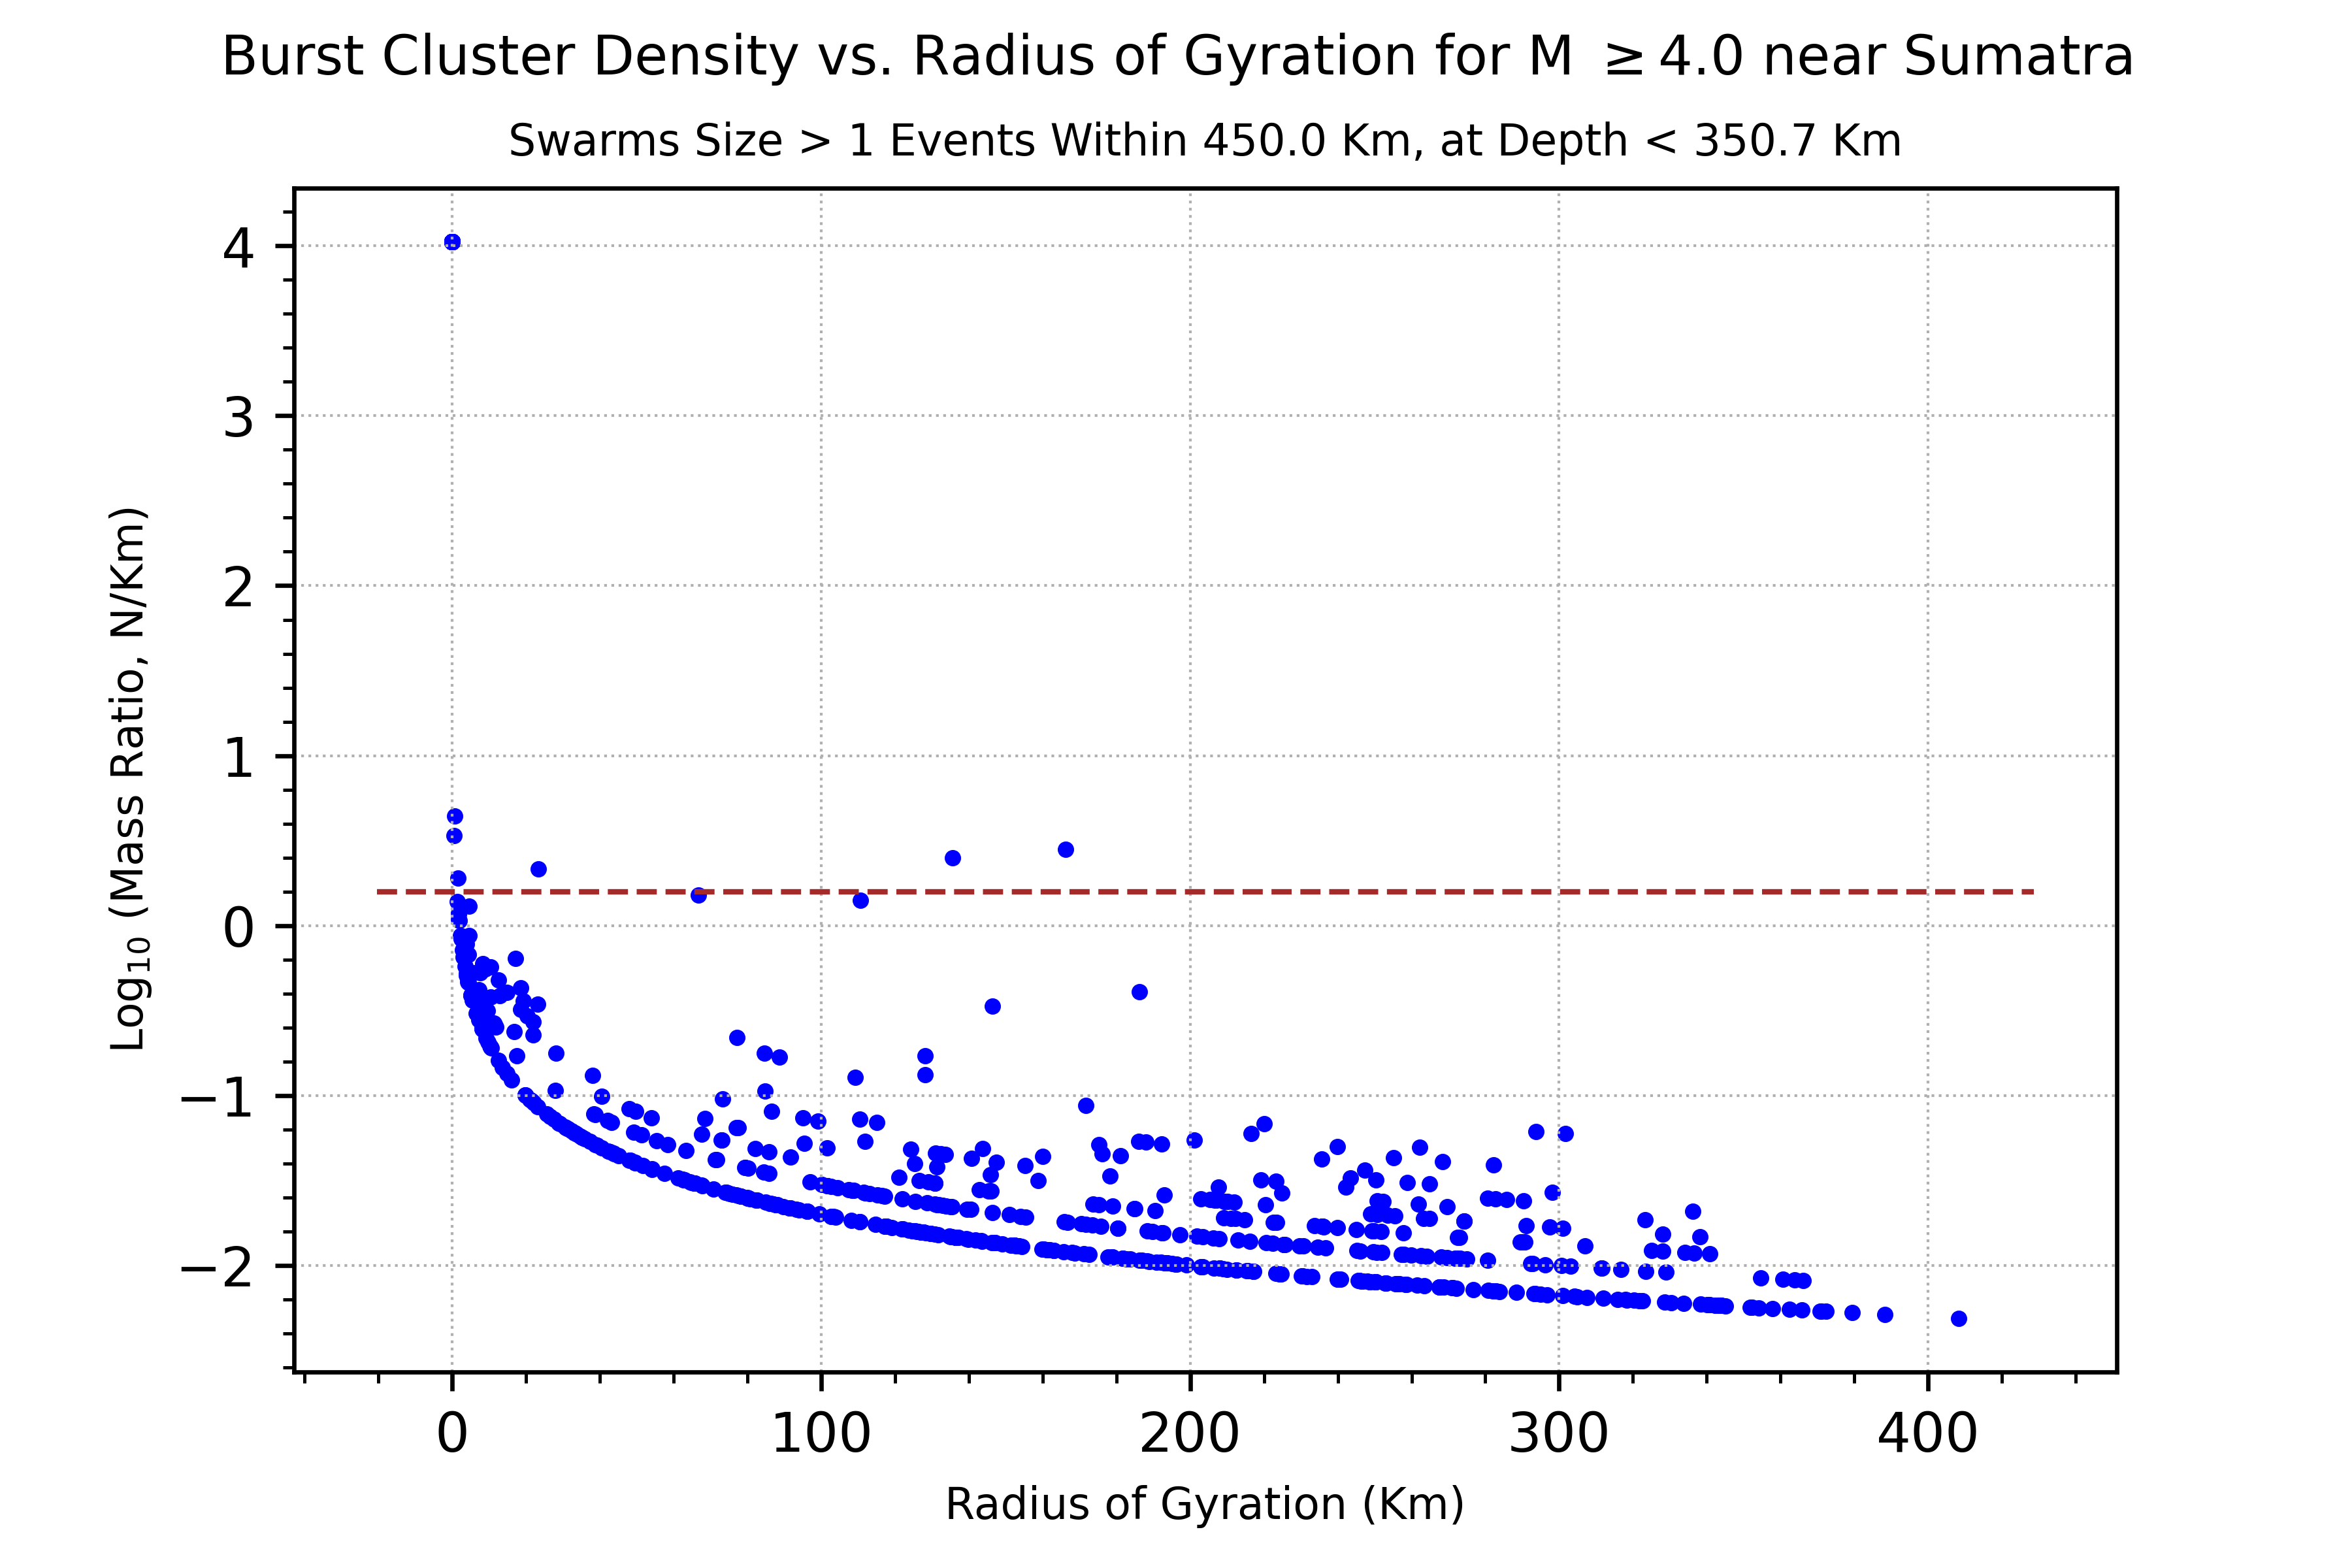

In [26]:
from google.colab.patches import cv2_imshow
import cv2

image = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_Density_RadGyr.png")
cv2_imshow(image)

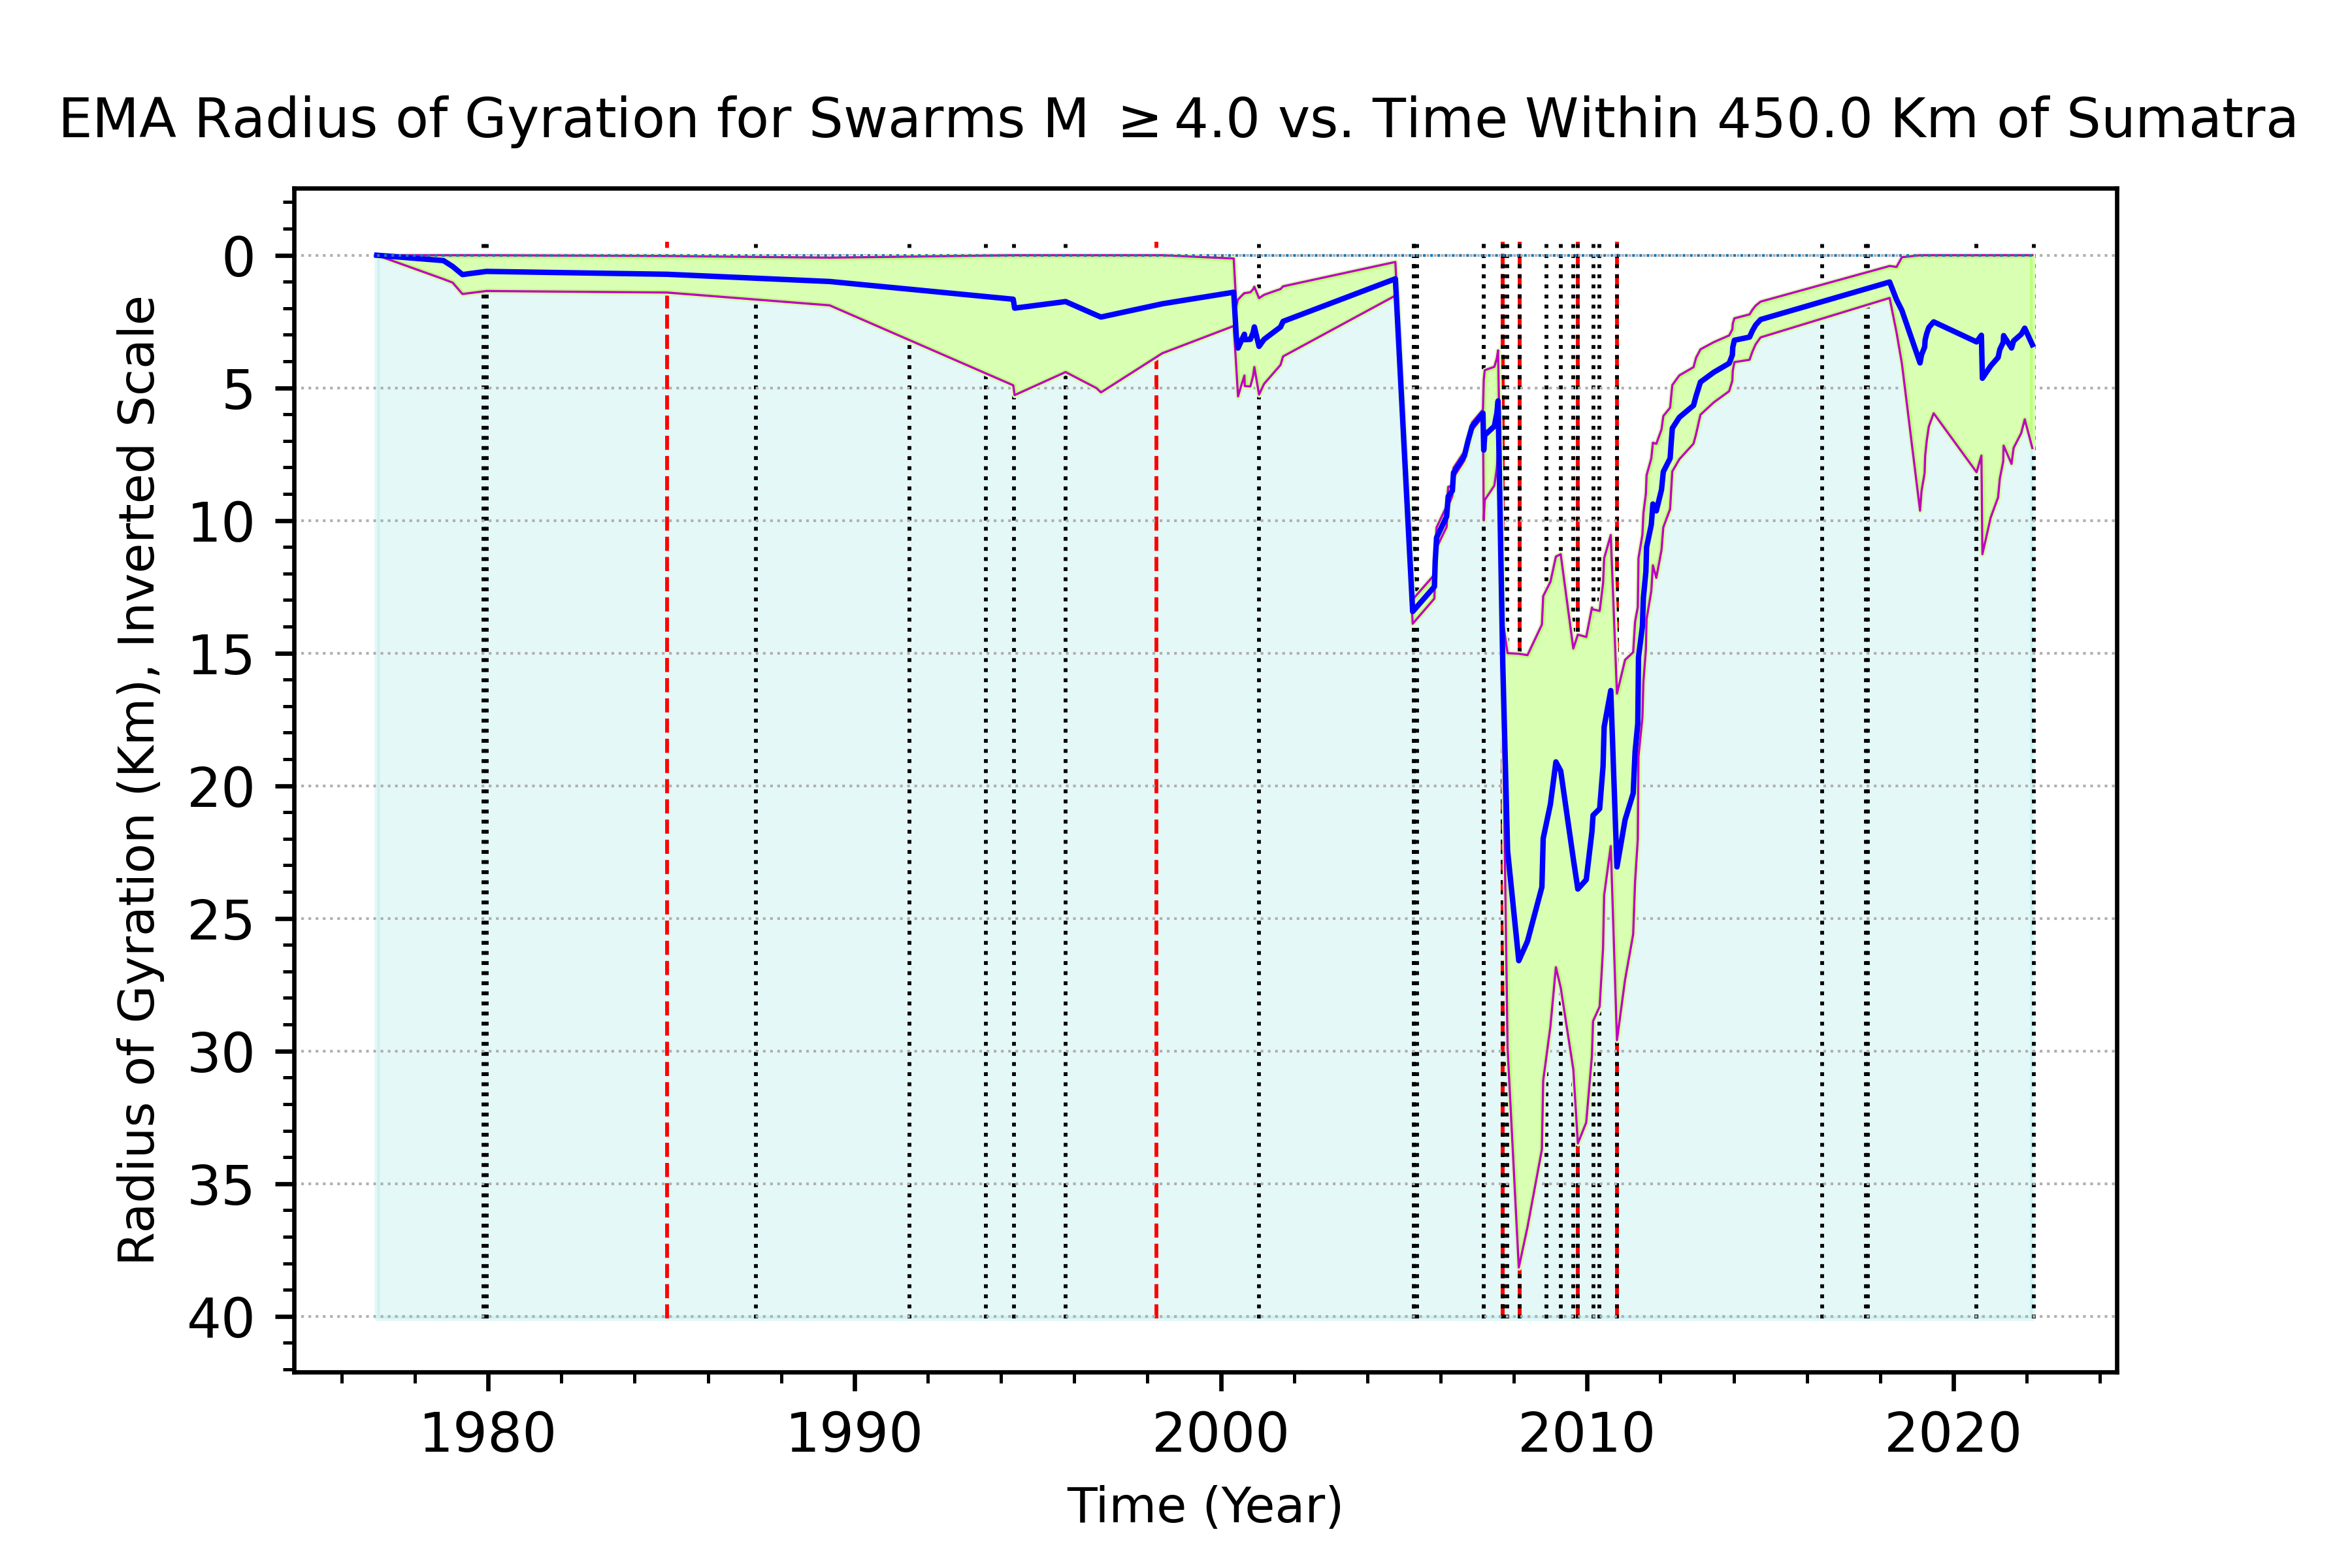

In [27]:
image2 = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_RadGyr_Time_EMA_Dev.png")
cv2_imshow(image2)

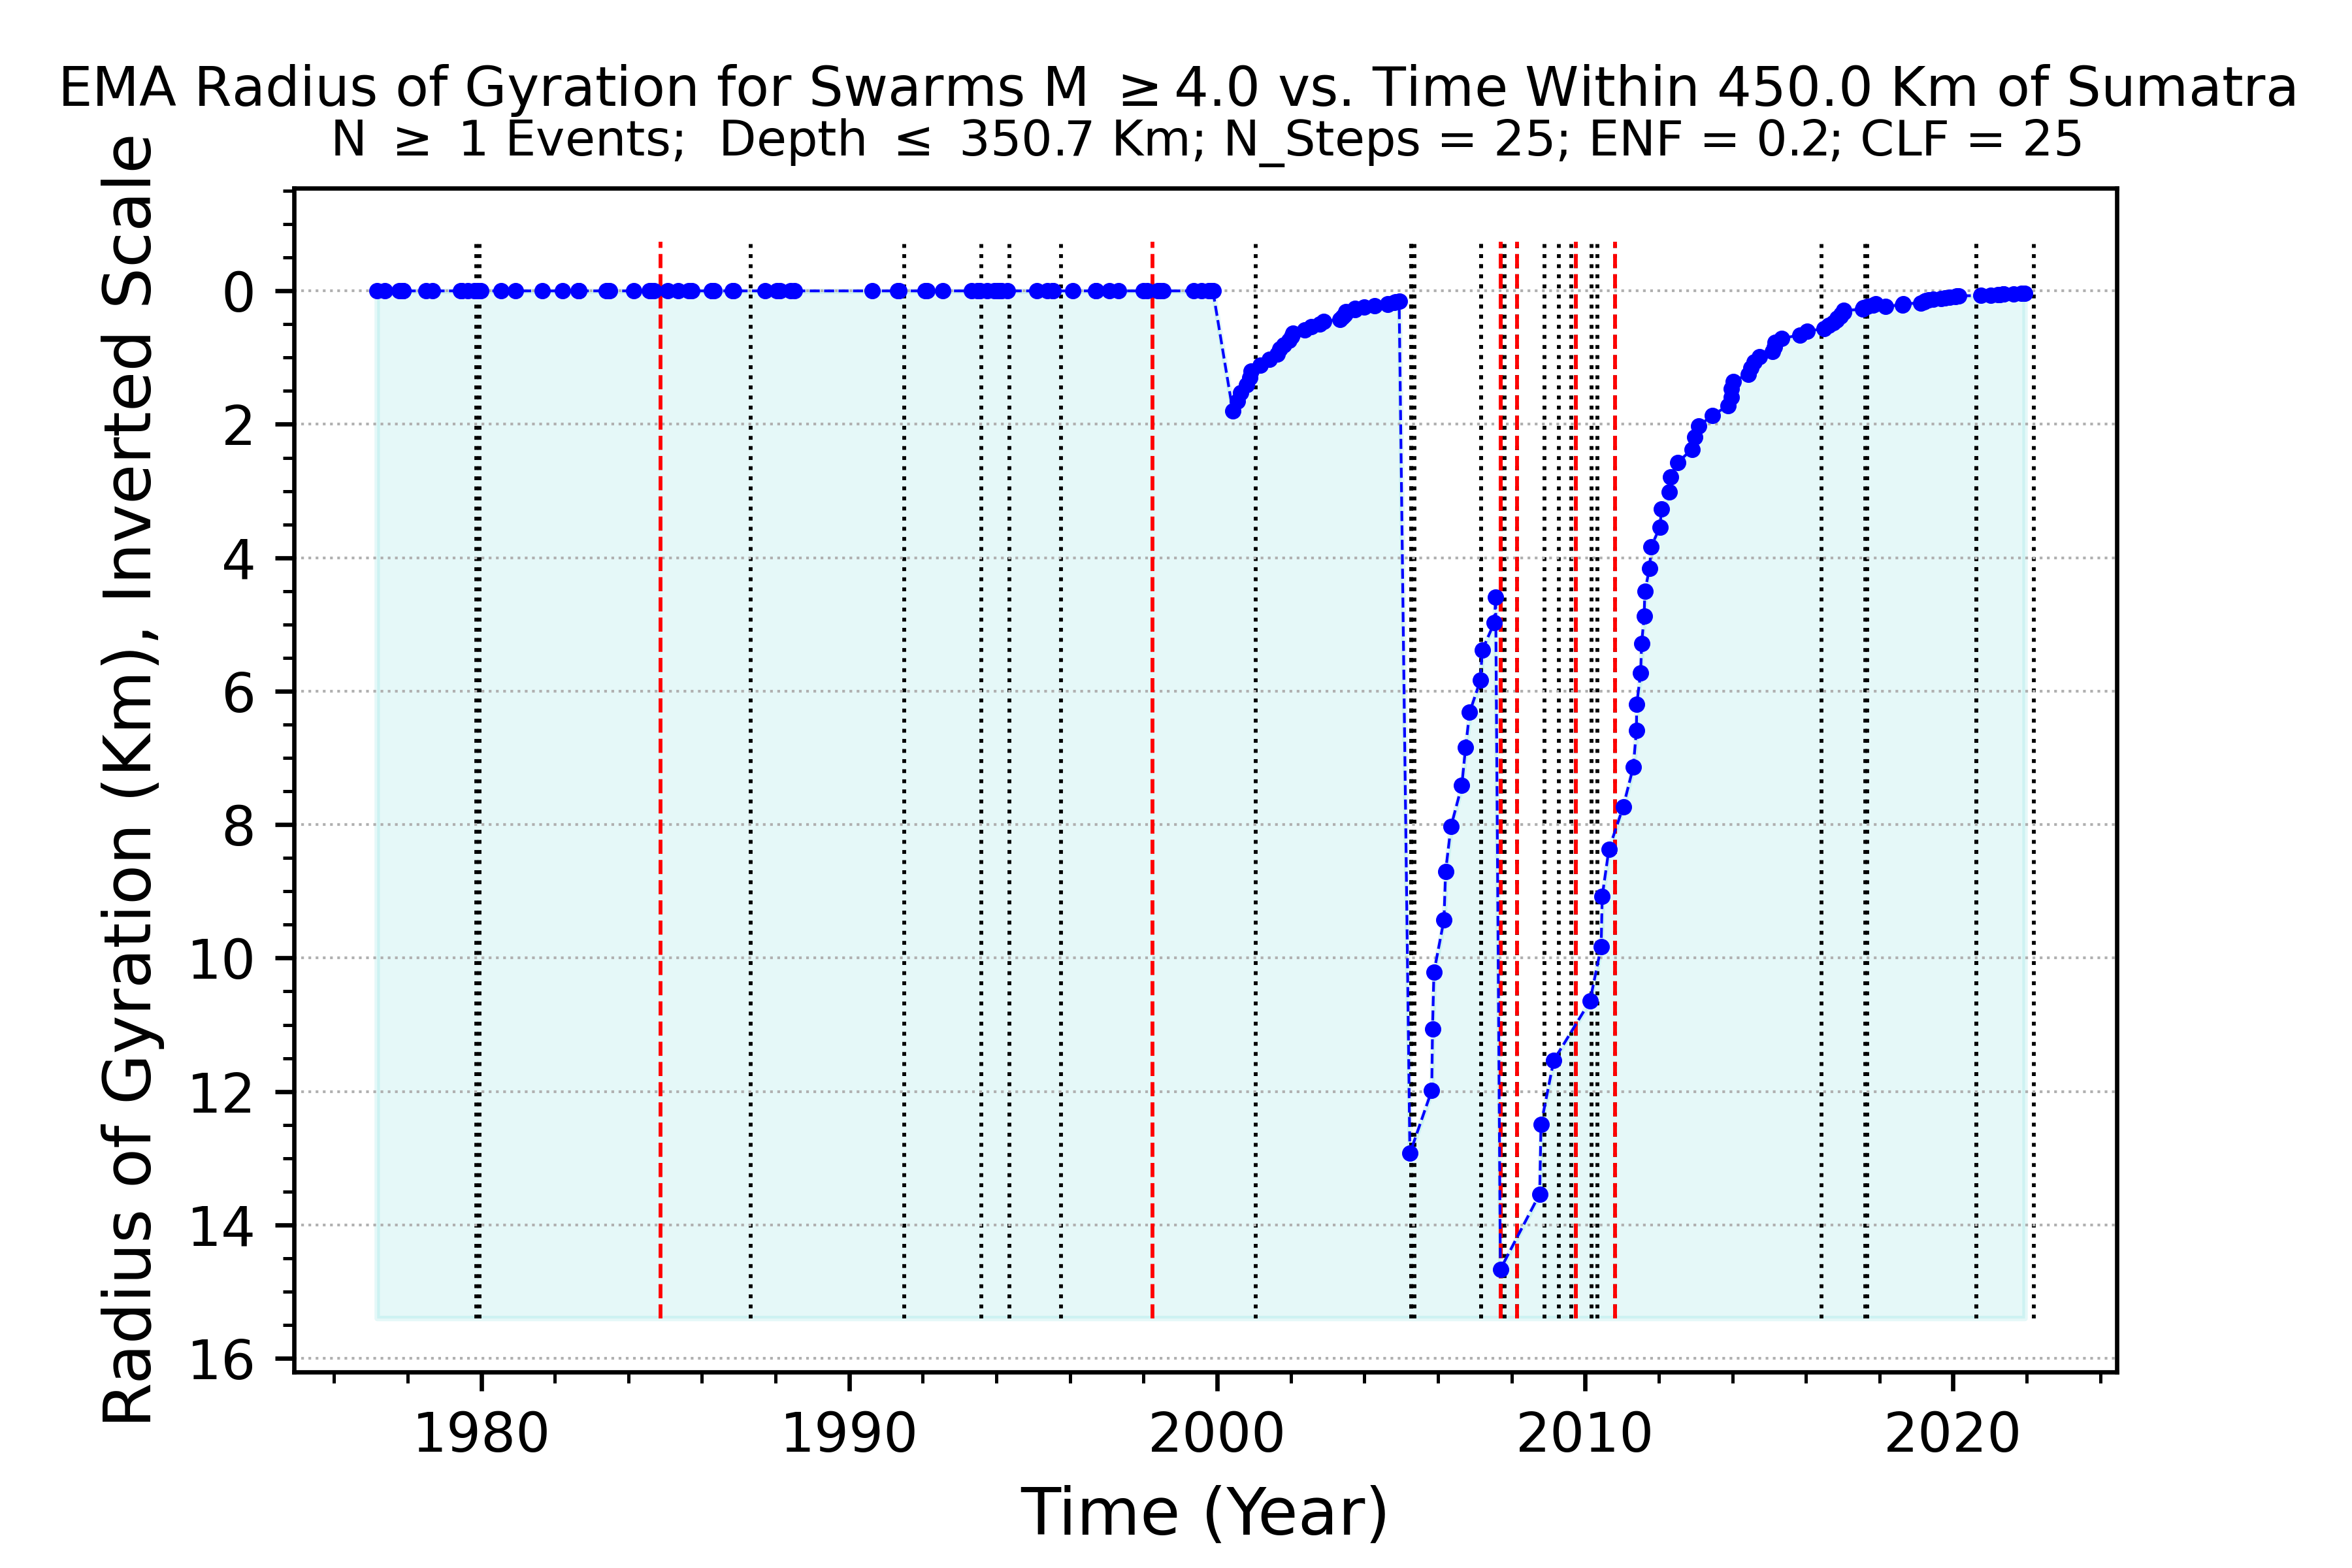

In [28]:
image2 = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_RadGyr_Time_EMA.png")
cv2_imshow(image2)

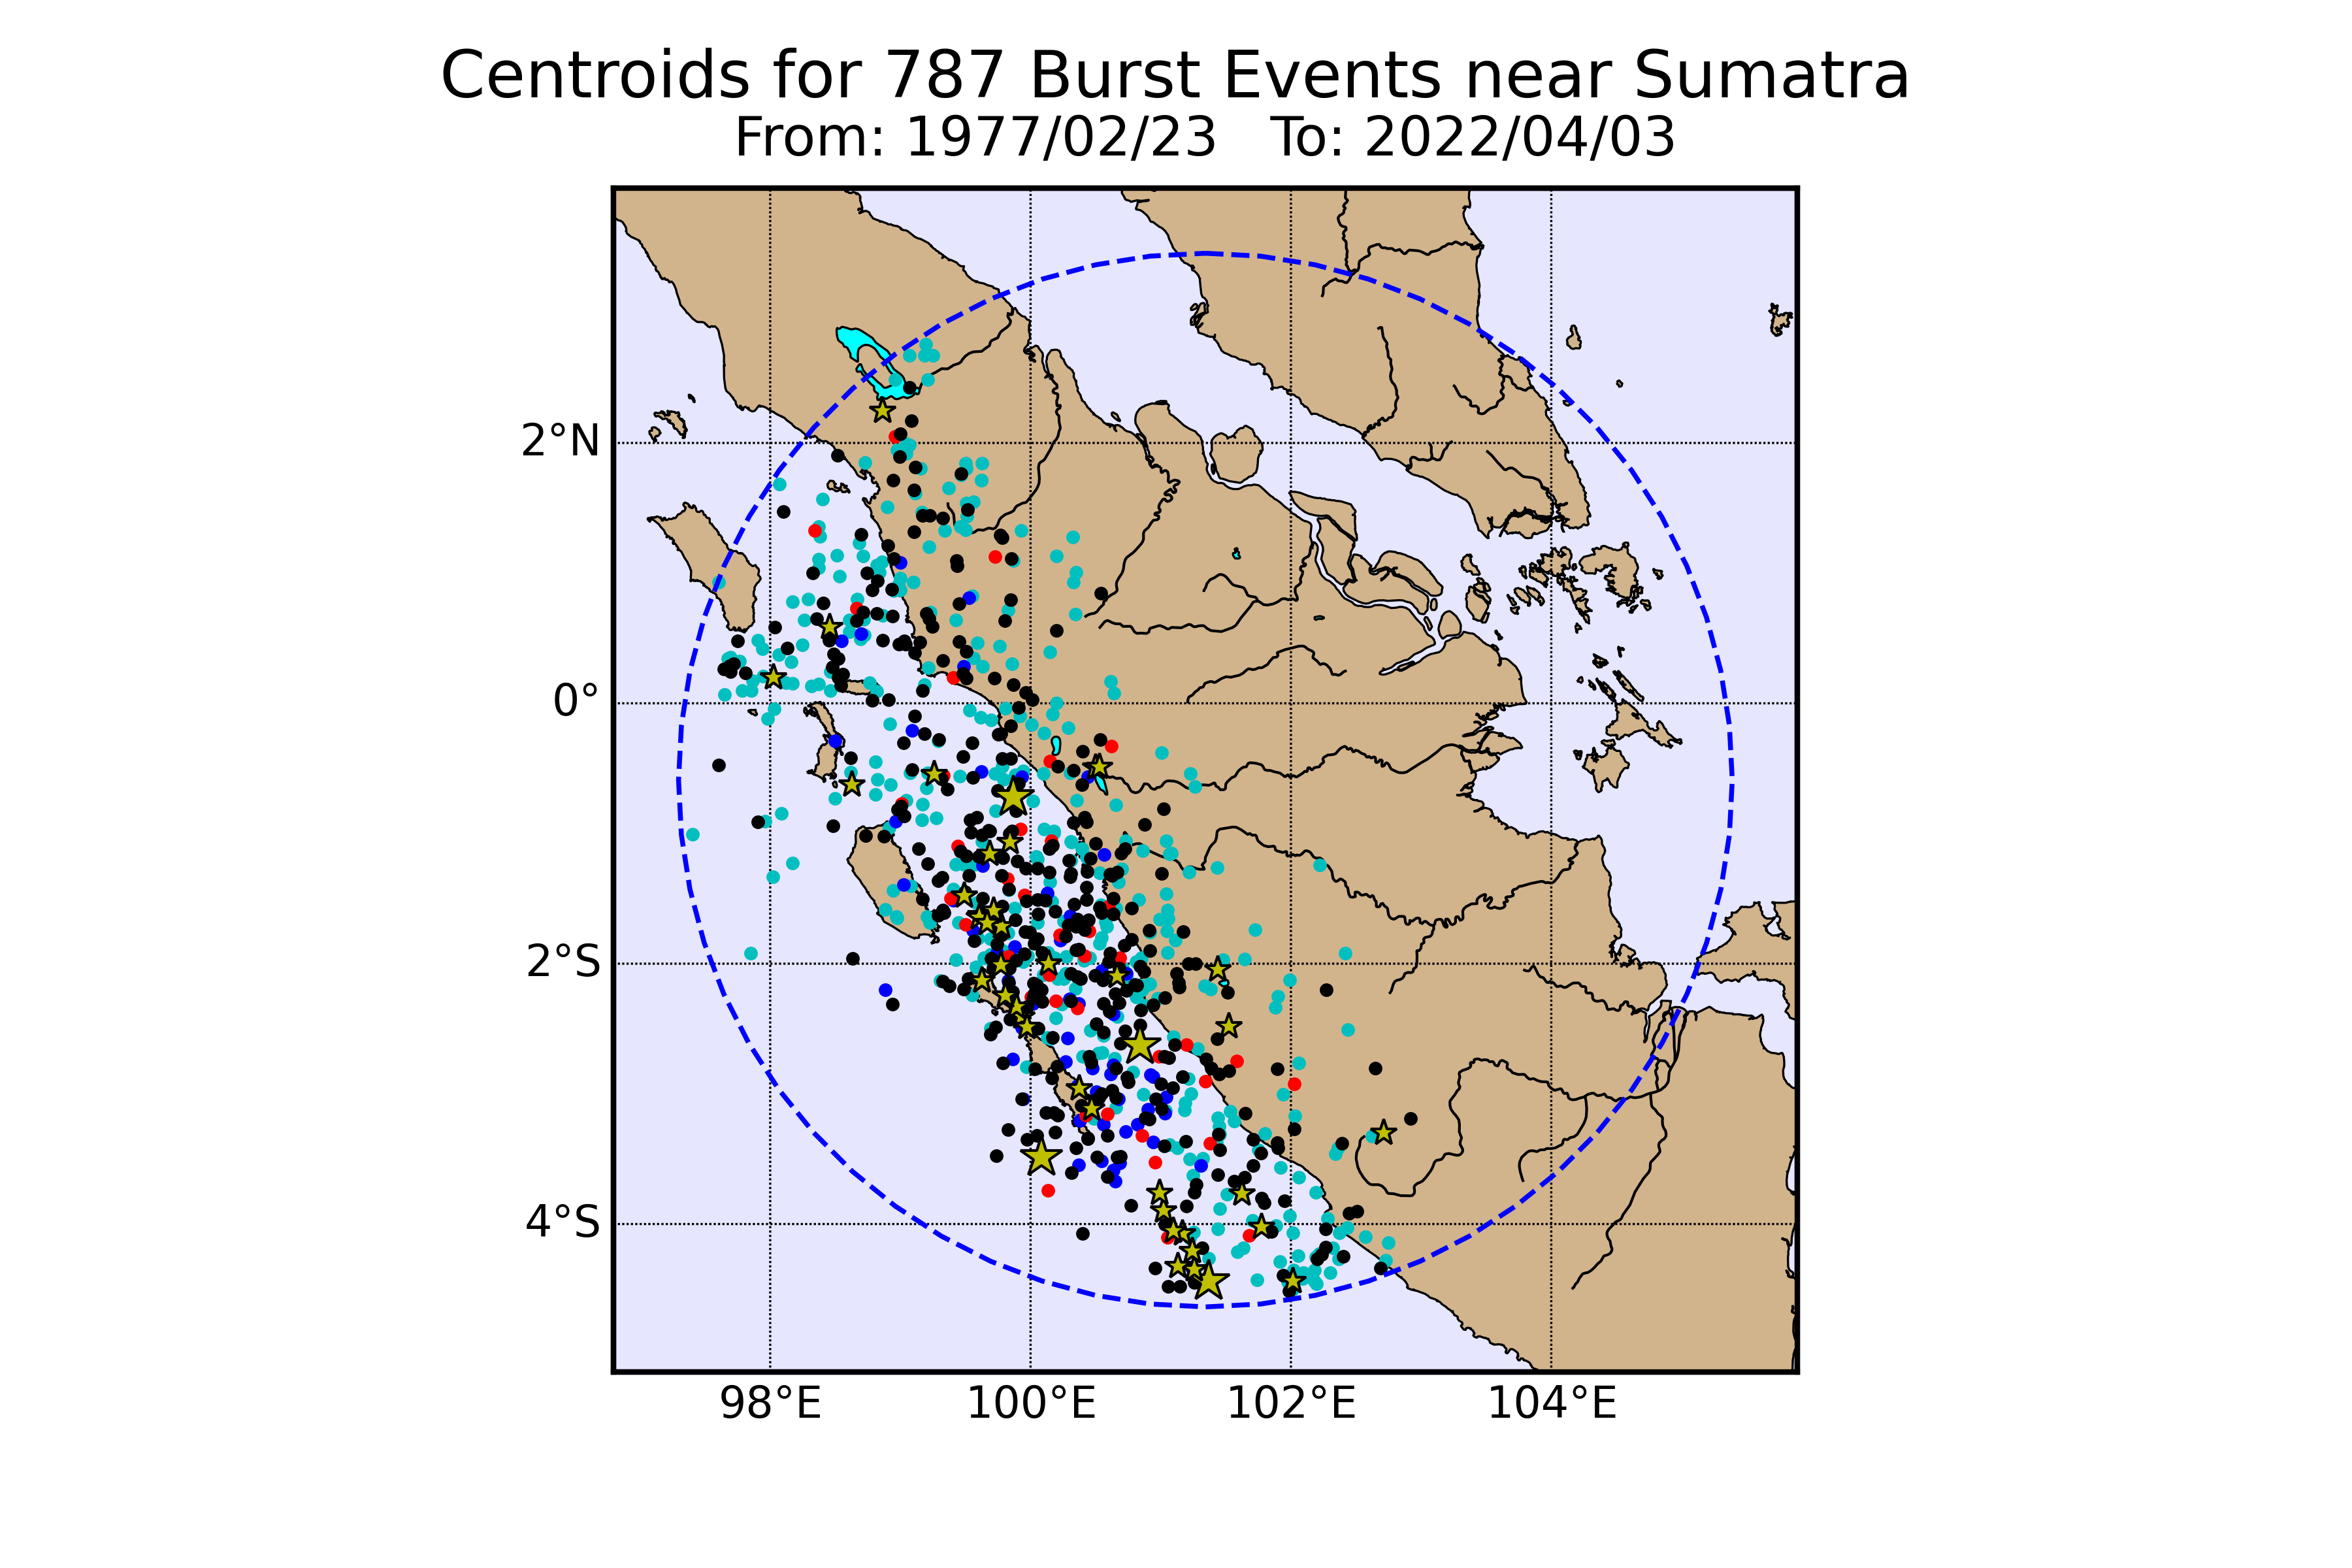

In [29]:
image2 = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_Swarm_Centroids.png")
cv2_imshow(image2)

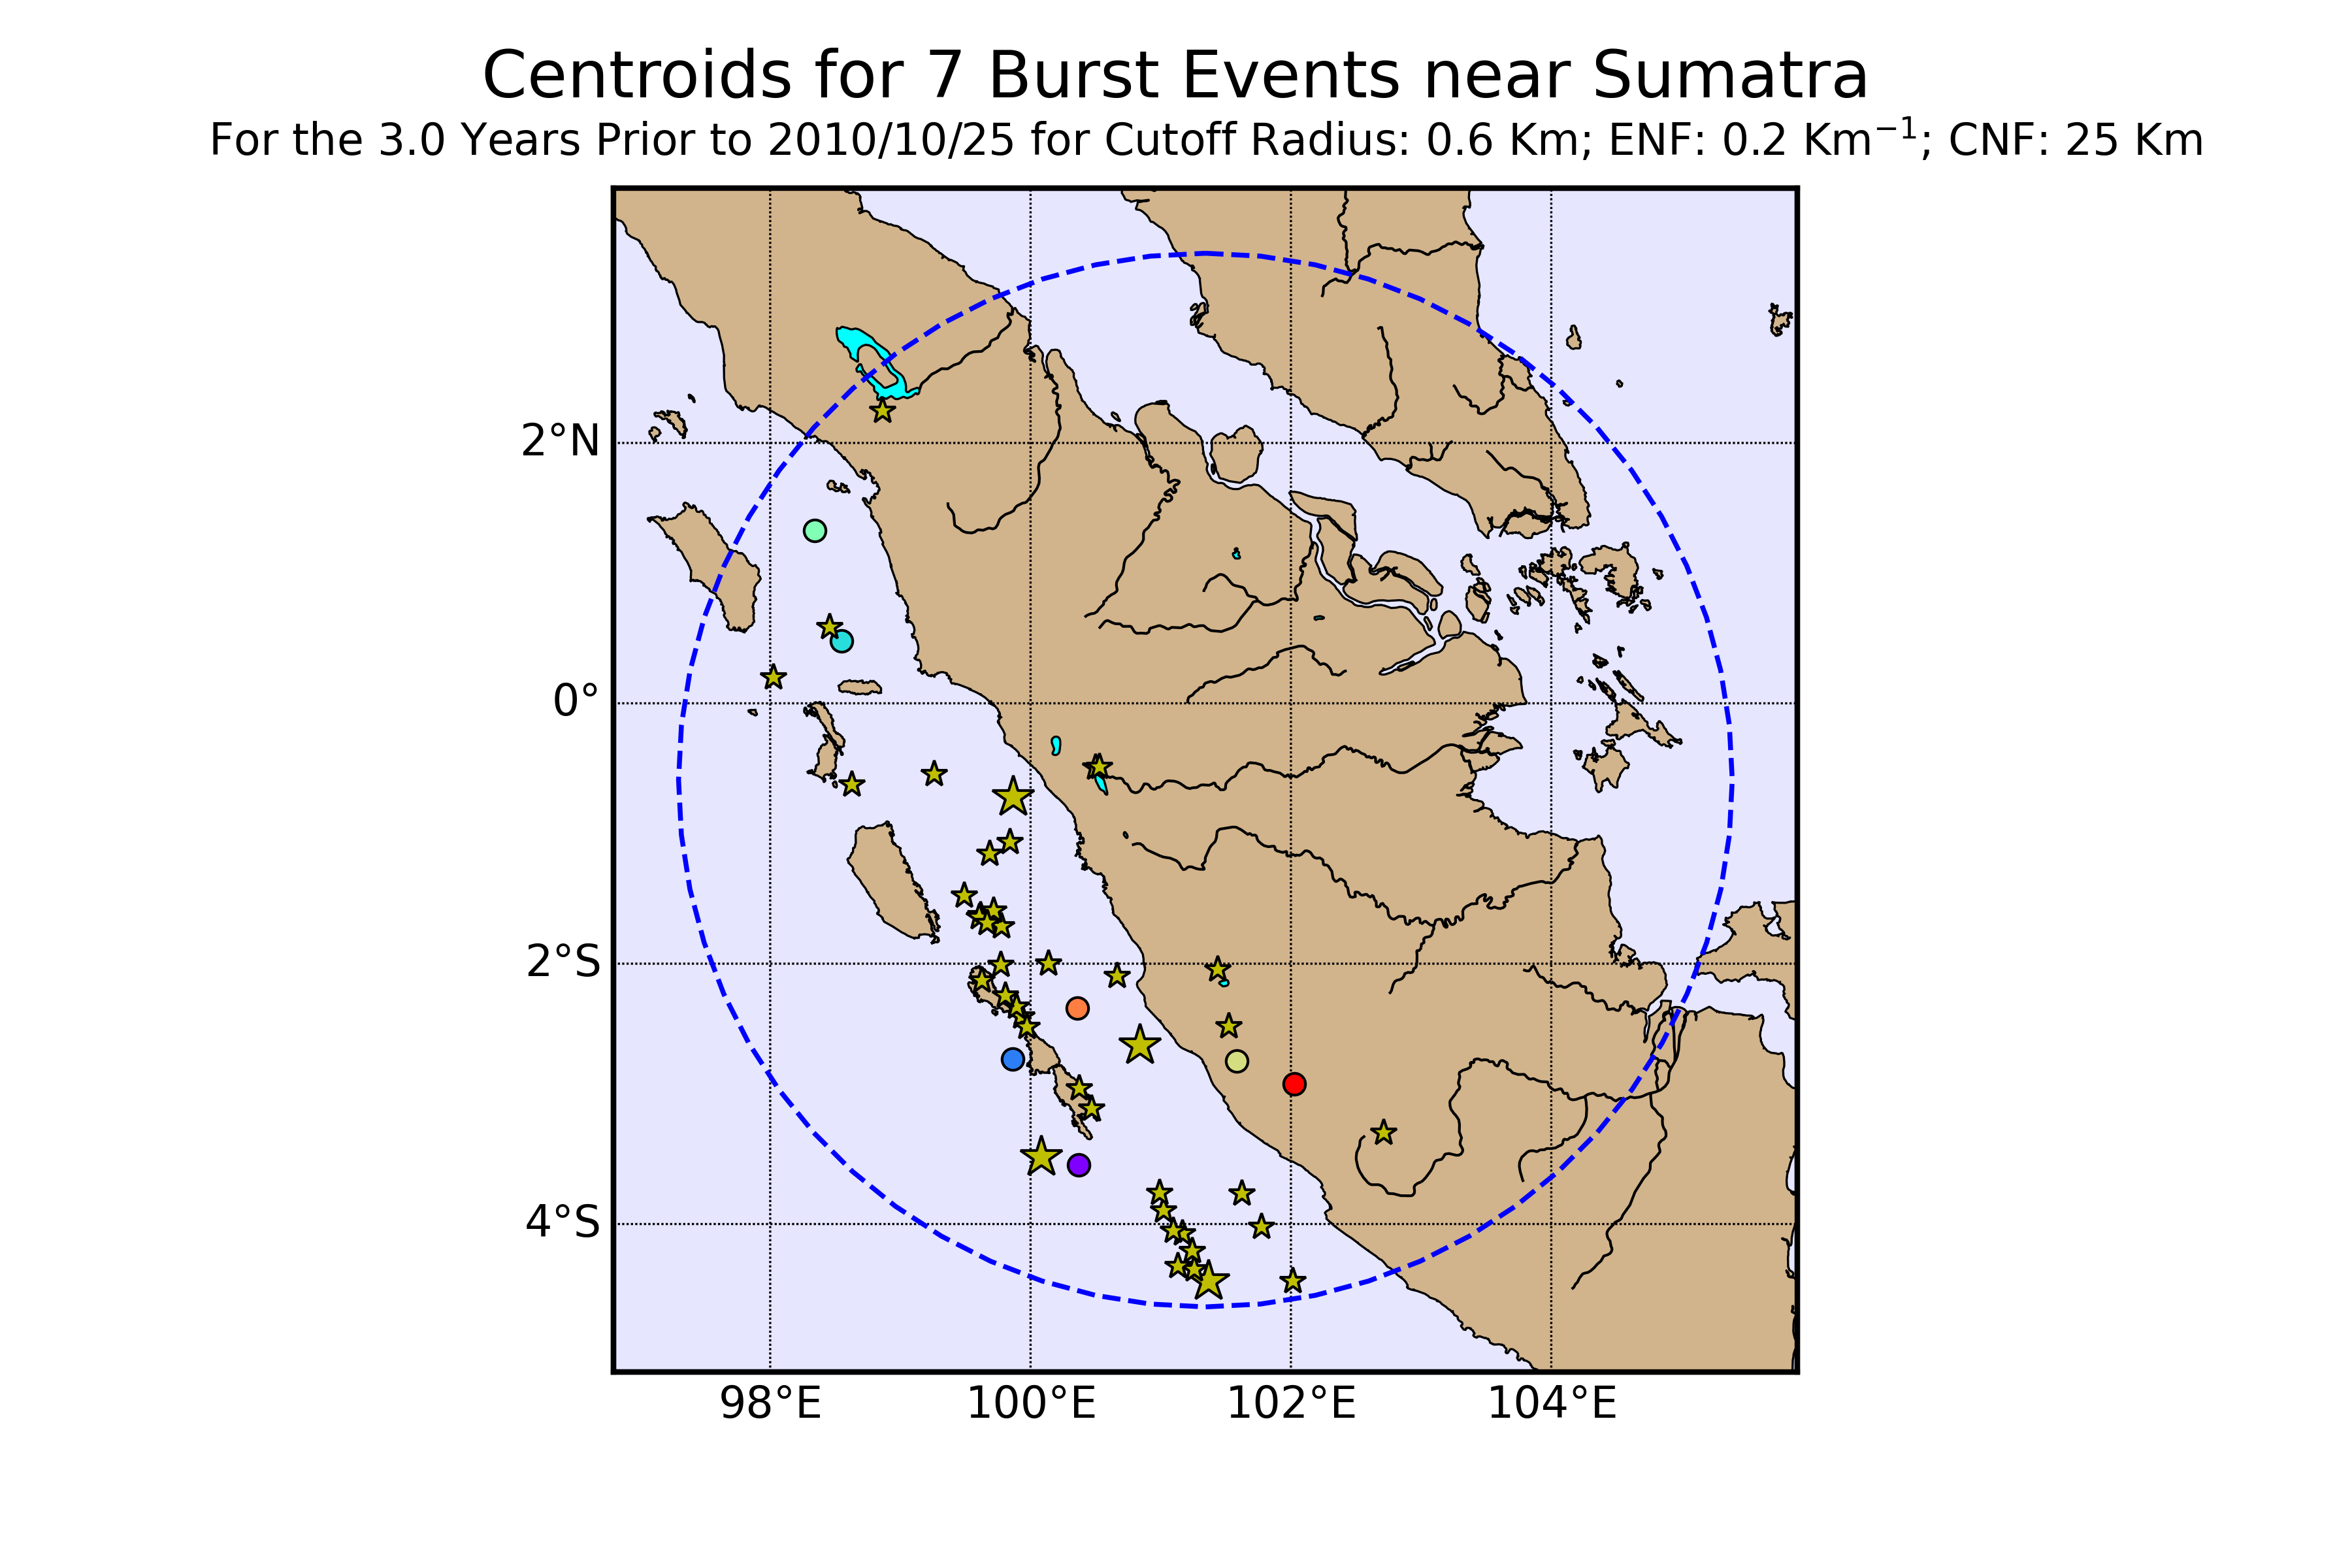

In [30]:
image2 = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_Swarm_Centroids_Dev.png")
cv2_imshow(image2)

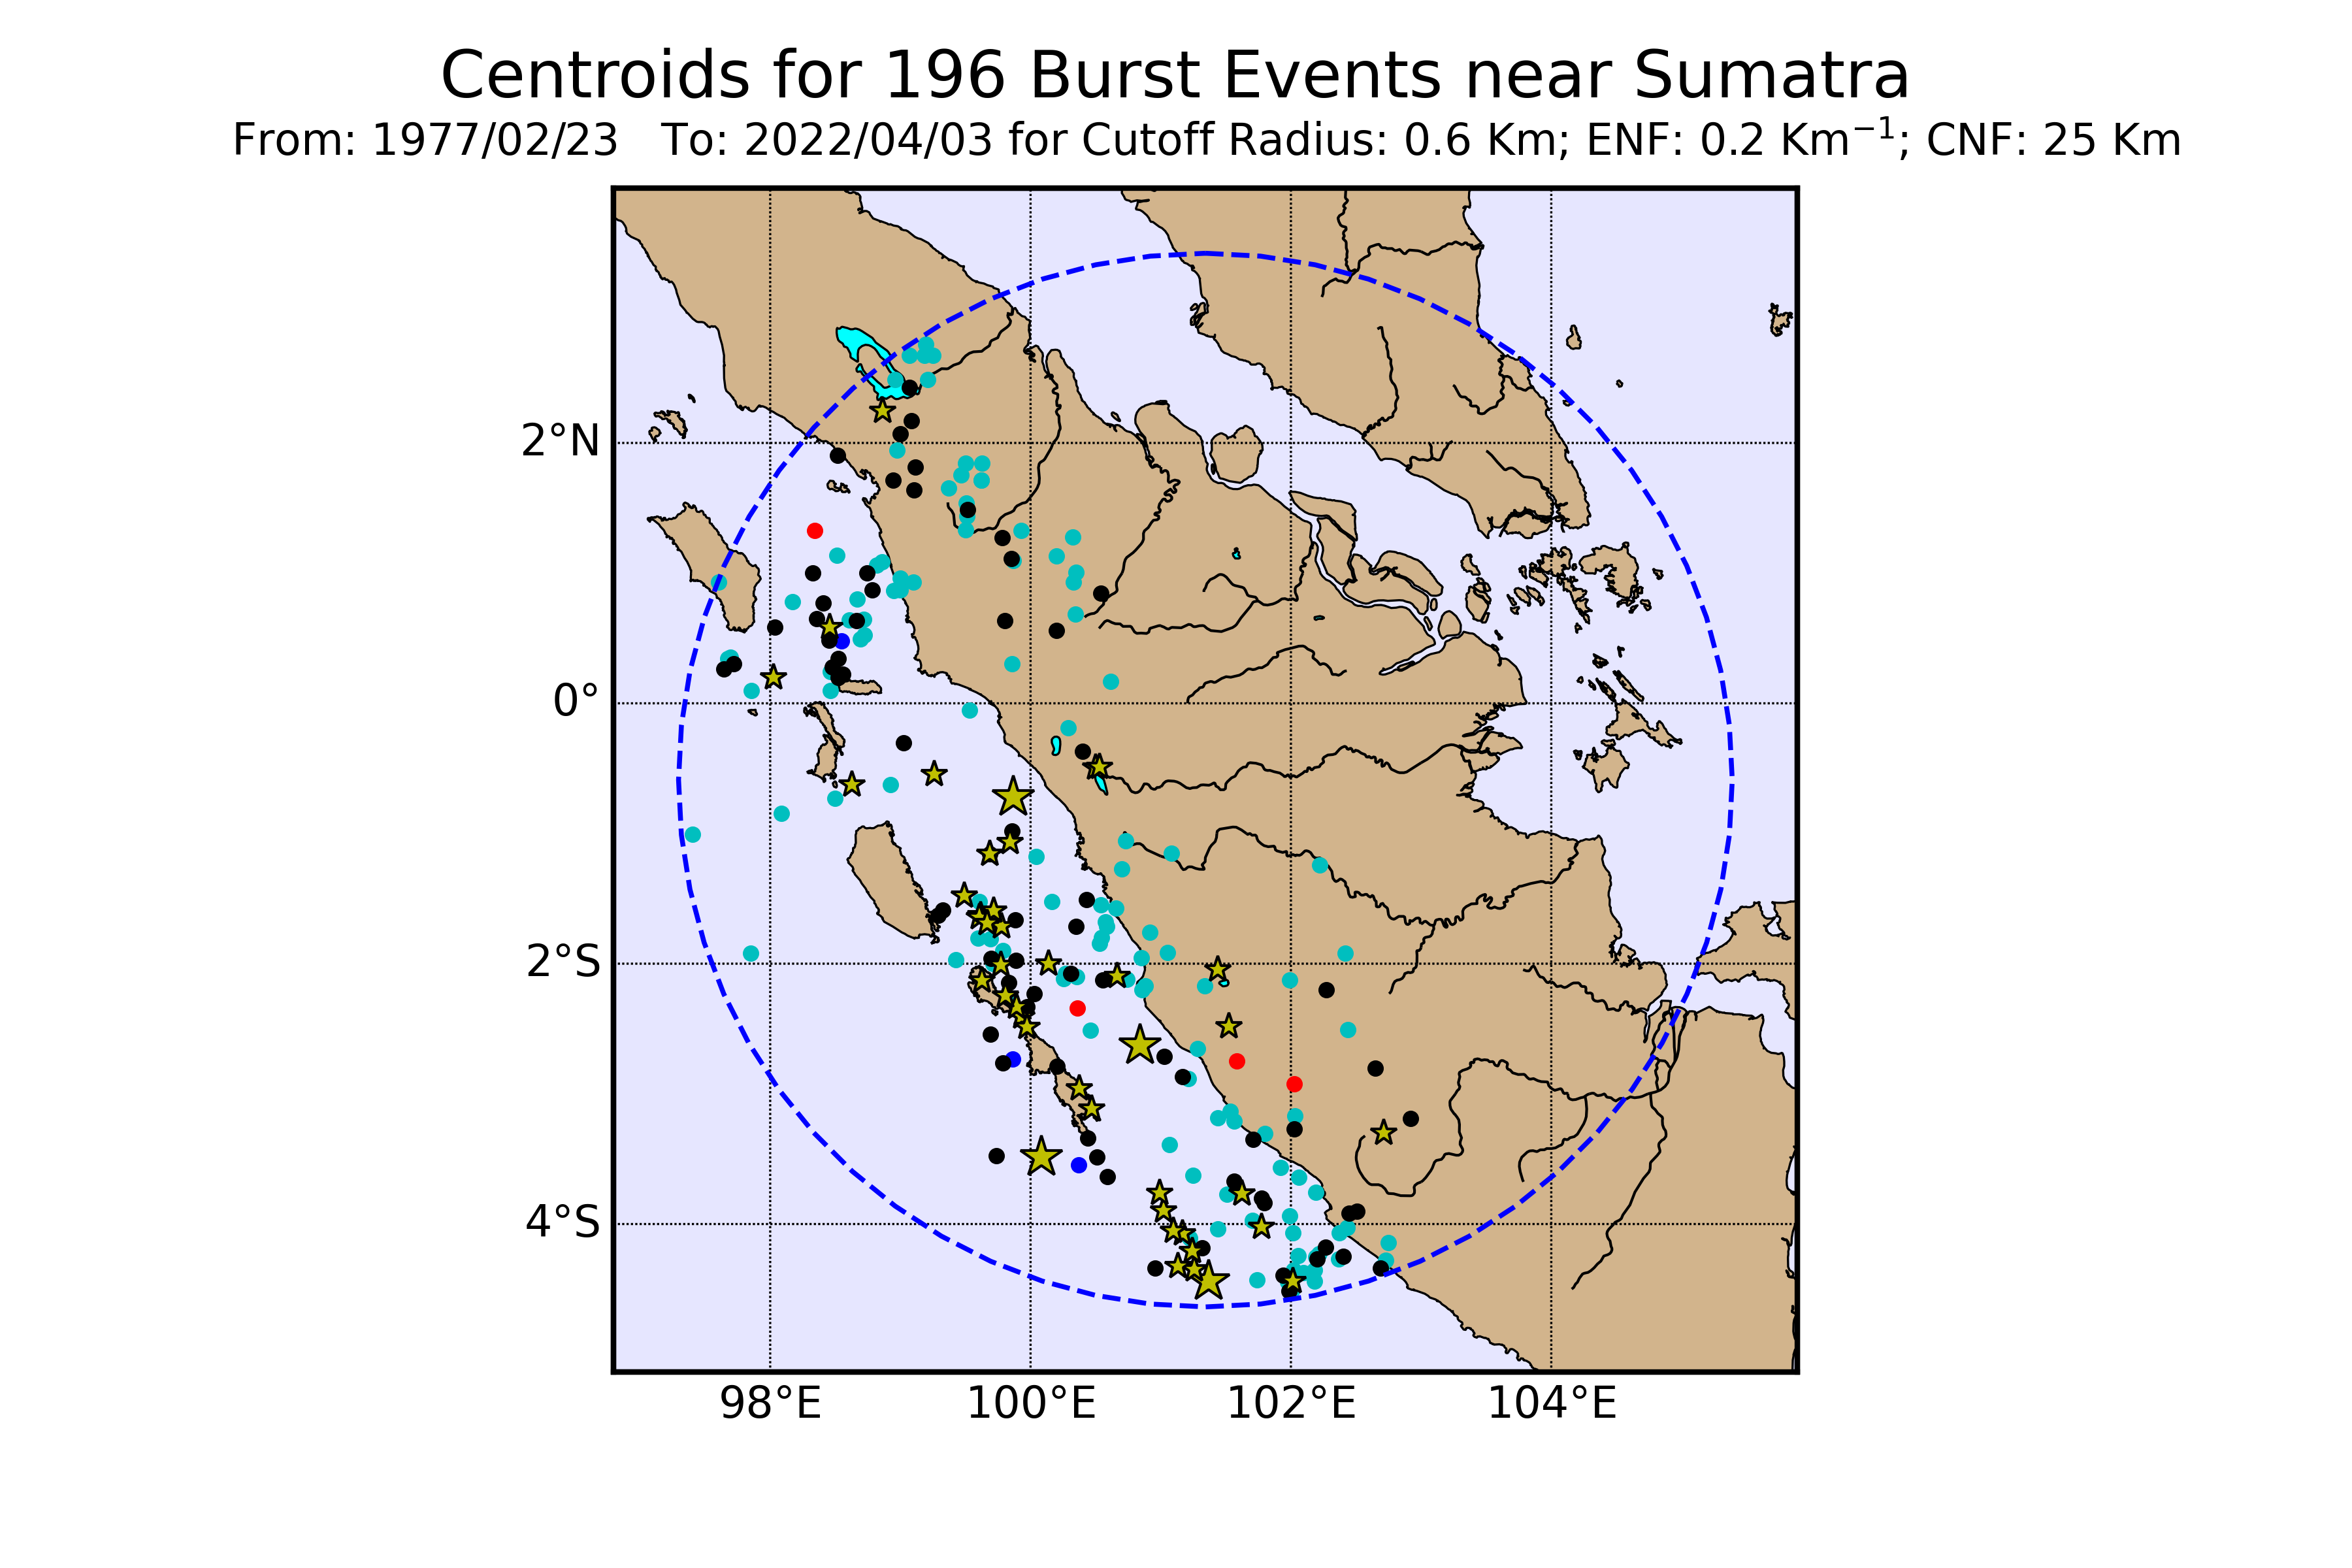

In [31]:
image2 = cv2.imread("/content/drive/MyDrive/dop_notebooks/Data/Sumatra_Swarm_Centroids_Alt.png")
cv2_imshow(image2)